In [ ]:
!pip install datasets


In [ ]:
# DeepSeek-R1-Distill-Qwen-1.5B GSM8K Benchmark with DeepEval and Token Blocking

# Install required packages
# !pip install -q transformers torch matplotlib pandas tqdm accelerate deepeval

# Import libraries
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, TextIteratorStreamer
import time
import re
import json
from datetime import datetime
import os
from threading import Thread
import gc
from tqdm.notebook import tqdm
import sys
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
from deepeval.benchmarks import GSM8K
from deepeval.models import CustomLLM

# Mount Google Drive for saving results
drive.mount('/content/drive')

# Create results directory in Google Drive
base_dir = "/content/drive/MyDrive/deepseek_gsm8k_results"
results_dir = os.path.join(base_dir, "block_words_benchmark")
os.makedirs(results_dir, exist_ok=True)
print(f"Results will be saved to: {results_dir}")

# Create a timestamp for this run
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
run_dir = os.path.join(results_dir, f"run_{timestamp}")
os.makedirs(run_dir, exist_ok=True)

# Define the words to block (using only the original set from your code)
words_to_block = ["wait", "alternatively", "perhaps", "maybe"]

def get_blocked_token_ids(tokenizer, words_to_block):
    """Get token IDs for words we want to block"""
    blocked_ids = []
    for word in words_to_block:
        # Get all possible token IDs for the word
        word_tokens = tokenizer.encode(" " + word, add_special_tokens=False)
        word_tokens.extend(tokenizer.encode(word, add_special_tokens=False))
        word_tokens.extend(tokenizer.encode(" " + word.capitalize(), add_special_tokens=False))
        word_tokens.extend(tokenizer.encode(word.capitalize(), add_special_tokens=False))
        word_tokens.extend(tokenizer.encode(" " + word.upper(), add_special_tokens=False))
        word_tokens.extend(tokenizer.encode(word.upper(), add_special_tokens=False))
        blocked_ids.extend(word_tokens)

    # Print the blocked words and their token IDs
    print(f"\nBlocking these words: {words_to_block}")
    unique_ids = list(set(blocked_ids))
    print(f"Corresponding to these {len(unique_ids)} token IDs: {unique_ids}")

    # Print token representations for debugging
    for token_id in unique_ids:
        print(f"Token ID {token_id} = '{tokenizer.decode([token_id])}'")

    return list(set(blocked_ids))

class TokenBlockLogitsProcessor:
    """Custom logits processor for token blocking"""
    def __init__(self, blocked_token_ids):
        self.blocked_token_ids = blocked_token_ids

    def __call__(self, input_ids, scores):
        # Create a mask of blocked tokens
        mask = torch.zeros_like(scores, dtype=torch.bool)
        mask[:, self.blocked_token_ids] = True
        # Set scores to -inf where mask is True
        scores = scores.masked_fill(mask, float('-inf'))
        return scores

class TokenBlockingLLM(CustomLLM):
    """Custom LLM with token blocking for use with deepeval"""

    def __init__(self, model, tokenizer, blocked_token_ids=None, temperature=0.7, top_p=0.9, top_k=40, max_tokens=512, save_dir=None):
        self.model = model
        self.tokenizer = tokenizer
        self.blocked_token_ids = blocked_token_ids
        self.temperature = temperature
        self.top_p = top_p
        self.top_k = top_k
        self.max_tokens = max_tokens
        self.save_dir = save_dir

        # Track statistics
        self.responses = []
        self.generation_times = []
        self.token_counts = []

    def generate(self, prompt):
        # Start timer
        start_time = time.time()

        # Prepare input
        inputs = self.tokenizer(
            prompt,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=1024
        ).to(self.model.device)

        input_tokens = inputs['input_ids'][0].cpu().tolist()

        # Create logits processor if blocked tokens are provided
        logits_processors = []
        if self.blocked_token_ids is not None:
            logits_processors.append(TokenBlockLogitsProcessor(self.blocked_token_ids))

        # Create streamer for token-by-token output
        streamer = TextIteratorStreamer(self.tokenizer, skip_special_tokens=True, skip_prompt=True)

        # Prepare generation kwargs
        generation_kwargs = dict(
            **inputs,
            max_new_tokens=self.max_tokens,
            temperature=self.temperature,
            top_p=self.top_p,
            top_k=self.top_k,
            do_sample=True,
            streamer=streamer,
            return_dict_in_generate=True,
            output_scores=True,
            logits_processor=logits_processors if logits_processors else None
        )

        # Run generation in a separate thread
        thread = Thread(target=self.model.generate, kwargs=generation_kwargs)
        thread.start()

        # Collect streamed tokens
        generated_text = ""
        output_tokens = []

        # Process streamed tokens
        for new_text in streamer:
            generated_text += new_text

            # Approximate token tracking
            new_token_ids = self.tokenizer.encode(new_text, add_special_tokens=False)
            output_tokens.extend(new_token_ids)

        # End timer
        generation_time = time.time() - start_time

        # Record stats
        self.responses.append({
            'prompt': prompt,
            'response': generated_text,
            'generation_time': generation_time,
            'tokens': len(output_tokens)
        })

        self.generation_times.append(generation_time)
        self.token_counts.append(len(output_tokens))

        # Save response if directory is provided
        if self.save_dir:
            # Create a filename based on prompt hash (to identify the same problems across runs)
            import hashlib
            prompt_hash = hashlib.md5(prompt.encode()).hexdigest()[:8]
            response_id = f"response_{prompt_hash}_{'blocked' if self.blocked_token_ids is not None else 'unblocked'}"

            response_data = {
                'prompt': prompt,
                'response': generated_text,
                'generation_time': generation_time,
                'tokens': len(output_tokens),
                'token_blocking': self.blocked_token_ids is not None
            }

            response_filepath = os.path.join(self.save_dir, f"{response_id}.json")
            with open(response_filepath, 'w') as f:
                json.dump(response_data, f, indent=2)

        return generated_text

    def get_avg_stats(self):
        """Get average statistics from all generated responses"""
        if not self.generation_times:
            return {'avg_time': 0, 'avg_tokens': 0}

        return {
            'avg_time': sum(self.generation_times) / len(self.generation_times),
            'avg_tokens': sum(self.token_counts) / len(self.token_counts)
        }

# Load the DeepSeek model
print("Loading DeepSeek-R1-Distill-Qwen-1.5B model...")
model_name = "deepseek-ai/deepseek-r1-distill-qwen-1.5b"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,  # Use half precision to fit in GPU memory
    device_map="auto"  # Automatically determine device mapping
)

# @title Run GSM8K Benchmark with DeepEval (With vs. Without Blocking)
# @markdown Configure the benchmark parameters

# @markdown ## Number of problems to test
n_problems = 50  # @param {type:"slider", min:10, max:200, step:10}
n_shots = 1  # @param {type:"slider", min:0, max:8, step:1}

# @markdown ## Generation parameters
temperature = 0.7  # @param {type:"slider", min:0.1, max:1.0, step:0.1}
top_p = 0.9  # @param {type:"slider", min:0.1, max:1.0, step:0.1}
top_k = 40  # @param {type:"number"}
max_tokens = 4000  # @param {type:"number"}

# Get blocked token IDs
blocked_token_ids = torch.tensor(
    get_blocked_token_ids(tokenizer, words_to_block),
    device=model.device
)

# Run benchmark without token blocking
print("\n===== Running GSM8K benchmark WITHOUT token blocking =====")
# Create custom LLM without token blocking
llm_unblocked = TokenBlockingLLM(
    model=model,
    tokenizer=tokenizer,
    blocked_token_ids=None,  # No blocking
    temperature=temperature,
    top_p=top_p,
    top_k=top_k,
    max_tokens=max_tokens,
    save_dir=run_dir
)

# Initialize benchmark
benchmark_unblocked = GSM8K(
    n_problems=n_problems,
    n_shots=n_shots,
    enable_cot=enable_cot
)

# Run evaluation
benchmark_unblocked.evaluate(model=llm_unblocked)

# Get statistics
unblocked_score = benchmark_unblocked.overall_score
unblocked_stats = llm_unblocked.get_avg_stats()

# Clear GPU memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    gc.collect()

# Run benchmark with token blocking
print("\n===== Running GSM8K benchmark WITH token blocking =====")
# Create custom LLM with token blocking
llm_blocked = TokenBlockingLLM(
    model=model,
    tokenizer=tokenizer,
    blocked_token_ids=blocked_token_ids,  # With blocking
    temperature=temperature,
    top_p=top_p,
    top_k=top_k,
    max_tokens=max_tokens,
    save_dir=run_dir
)

# Initialize benchmark
benchmark_blocked = GSM8K(
    n_problems=n_problems,
    n_shots=n_shots,
    enable_cot=enable_cot
)

# Run evaluation
benchmark_blocked.evaluate(model=llm_blocked)

# Get statistics
blocked_score = benchmark_blocked.overall_score
blocked_stats = llm_blocked.get_avg_stats()

# Create summary report
summary = {
    'model': model_name,
    'timestamp': timestamp,
    'n_problems': n_problems,
    'n_shots': n_shots,
    'enable_cot': enable_cot,
    'words_blocked': words_to_block,
    'generation_params': {
        'temperature': temperature,
        'top_p': top_p,
        'top_k': top_k,
        'max_tokens': max_tokens
    },
    'unblocked': {
        'score': unblocked_score,
        'avg_time': unblocked_stats['avg_time'],
        'avg_tokens': unblocked_stats['avg_tokens']
    },
    'blocked': {
        'score': blocked_score,
        'avg_time': blocked_stats['avg_time'],
        'avg_tokens': blocked_stats['avg_tokens']
    },
    'difference': {
        'score': blocked_score - unblocked_score,
        'time': blocked_stats['avg_time'] - unblocked_stats['avg_time'],
        'tokens': blocked_stats['avg_tokens'] - unblocked_stats['avg_tokens']
    }
}

# Save summary to file
summary_filepath = os.path.join(run_dir, f"summary_{timestamp}.json")
with open(summary_filepath, 'w') as f:
    json.dump(summary, f, indent=2)

# Create dataframe for display
df = pd.DataFrame([
    {
        'Method': 'Without Blocking',
        'GSM8K Score (%)': unblocked_score,
        'Avg Time (s)': unblocked_stats['avg_time'],
        'Avg Tokens': unblocked_stats['avg_tokens']
    },
    {
        'Method': 'With Blocking',
        'GSM8K Score (%)': blocked_score,
        'Avg Time (s)': blocked_stats['avg_time'],
        'Avg Tokens': blocked_stats['avg_tokens']
    }
])

# Display results
print("\n===== Final Results =====")
print(df)
print(f"\nBlocked words: {words_to_block}")
print(f"\nDifference in score: {blocked_score - unblocked_score:.2f} percentage points")
print(f"Difference in avg time: {blocked_stats['avg_time'] - unblocked_stats['avg_time']:.2f} seconds")
print(f"Difference in avg tokens: {blocked_stats['avg_tokens'] - unblocked_stats['avg_tokens']:.1f} tokens")

# Create visualization
plt.figure(figsize=(12, 10))

# Plot accuracy
plt.subplot(3, 1, 1)
plt.bar(['Without Blocking', 'With Blocking'], [unblocked_score, blocked_score], color=['skyblue', 'lightgreen'])
plt.title(f'GSM8K Score Comparison\n(DeepSeek-R1-Distill-Qwen-1.5B)')
plt.ylabel('Score (%)')
plt.ylim(0, 100)

# Plot avg time
plt.subplot(3, 1, 2)
plt.bar(['Without Blocking', 'With Blocking'], [unblocked_stats['avg_time'], blocked_stats['avg_time']], color=['skyblue', 'lightgreen'])
plt.title('Average Generation Time per Problem')
plt.ylabel('Time (seconds)')

# Plot avg tokens
plt.subplot(3, 1, 3)
plt.bar(['Without Blocking', 'With Blocking'], [unblocked_stats['avg_tokens'], blocked_stats['avg_tokens']], color=['skyblue', 'lightgreen'])
plt.title('Average Tokens Generated per Problem')
plt.ylabel('Tokens')

plt.tight_layout()
plt.savefig(os.path.join(run_dir, f"comparison_{timestamp}.png"))
plt.show()

print(f"\nAll results saved to: {run_dir}")

ImportError: cannot import name 'CustomLLM' from 'deepeval.models' (/usr/local/lib/python3.11/dist-packages/deepeval/models/__init__.py)

In [ ]:
# DeepSeek-R1-Distill-Qwen-1.5B GSM8K Benchmark with DeepEval and Token Blocking

# Install required packages
# !pip install -q transformers torch matplotlib pandas tqdm accelerate
!pip install -q deepeval --upgrade

# Import libraries
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, TextIteratorStreamer
import time
import re
import json
from datetime import datetime
import os
from threading import Thread
import gc
from tqdm.notebook import tqdm
import sys
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
from deepeval.benchmarks import GSM8K
from deepeval.models.base_model import BaseModel  # Use BaseModel instead of CustomLLM

# Mount Google Drive for saving results
drive.mount('/content/drive')

# Create results directory in Google Drive
base_dir = "/content/drive/MyDrive/deepseek_gsm8k_results"
results_dir = os.path.join(base_dir, "block_words_benchmark")
os.makedirs(results_dir, exist_ok=True)
print(f"Results will be saved to: {results_dir}")

# Create a timestamp for this run
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
run_dir = os.path.join(results_dir, f"run_{timestamp}")
os.makedirs(run_dir, exist_ok=True)

# Define the words to block (using only the original set from your code)
words_to_block = ["wait", "alternatively", "perhaps", "maybe"]

def get_blocked_token_ids(tokenizer, words_to_block):
    """Get token IDs for words we want to block"""
    blocked_ids = []
    for word in words_to_block:
        # Get all possible token IDs for the word
        word_tokens = tokenizer.encode(" " + word, add_special_tokens=False)
        word_tokens.extend(tokenizer.encode(word, add_special_tokens=False))
        word_tokens.extend(tokenizer.encode(" " + word.capitalize(), add_special_tokens=False))
        word_tokens.extend(tokenizer.encode(word.capitalize(), add_special_tokens=False))
        word_tokens.extend(tokenizer.encode(" " + word.upper(), add_special_tokens=False))
        word_tokens.extend(tokenizer.encode(word.upper(), add_special_tokens=False))
        blocked_ids.extend(word_tokens)

    # Print the blocked words and their token IDs
    print(f"\nBlocking these words: {words_to_block}")
    unique_ids = list(set(blocked_ids))
    print(f"Corresponding to these {len(unique_ids)} token IDs: {unique_ids}")

    # Print token representations for debugging
    for token_id in unique_ids:
        print(f"Token ID {token_id} = '{tokenizer.decode([token_id])}'")

    return list(set(blocked_ids))

class TokenBlockLogitsProcessor:
    """Custom logits processor for token blocking"""
    def __init__(self, blocked_token_ids):
        self.blocked_token_ids = blocked_token_ids

    def __call__(self, input_ids, scores):
        # Create a mask of blocked tokens
        mask = torch.zeros_like(scores, dtype=torch.bool)
        mask[:, self.blocked_token_ids] = True
        # Set scores to -inf where mask is True
        scores = scores.masked_fill(mask, float('-inf'))
        return scores

class TokenBlockingLLM(BaseModel):
    """Custom LLM with token blocking for use with deepeval"""

    def __init__(self, model, tokenizer, blocked_token_ids=None, temperature=0.7, top_p=0.9, top_k=40, max_tokens=512, save_dir=None):
        self.model = model
        self.tokenizer = tokenizer
        self.blocked_token_ids = blocked_token_ids
        self.temperature = temperature
        self.top_p = top_p
        self.top_k = top_k
        self.max_tokens = max_tokens
        self.save_dir = save_dir

        # Track statistics
        self.responses = []
        self.generation_times = []
        self.token_counts = []

    def complete(self, prompt):
        """Implementation of the required complete method from BaseModel"""
        return self.generate(prompt)

    def generate(self, prompt):
        # Start timer
        start_time = time.time()

        # Prepare input
        inputs = self.tokenizer(
            prompt,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=1024
        ).to(self.model.device)

        input_tokens = inputs['input_ids'][0].cpu().tolist()

        # Create logits processor if blocked tokens are provided
        logits_processors = []
        if self.blocked_token_ids is not None:
            logits_processors.append(TokenBlockLogitsProcessor(self.blocked_token_ids))

        # Create streamer for token-by-token output
        streamer = TextIteratorStreamer(self.tokenizer, skip_special_tokens=True, skip_prompt=True)

        # Prepare generation kwargs
        generation_kwargs = dict(
            **inputs,
            max_new_tokens=self.max_tokens,
            temperature=self.temperature,
            top_p=self.top_p,
            top_k=self.top_k,
            do_sample=True,
            streamer=streamer,
            return_dict_in_generate=True,
            output_scores=True,
            logits_processor=logits_processors if logits_processors else None
        )

        # Run generation in a separate thread
        thread = Thread(target=self.model.generate, kwargs=generation_kwargs)
        thread.start()

        # Collect streamed tokens
        generated_text = ""
        output_tokens = []

        # Process streamed tokens
        for new_text in streamer:
            generated_text += new_text

            # Approximate token tracking
            new_token_ids = self.tokenizer.encode(new_text, add_special_tokens=False)
            output_tokens.extend(new_token_ids)

        # End timer
        generation_time = time.time() - start_time

        # Record stats
        self.responses.append({
            'prompt': prompt,
            'response': generated_text,
            'generation_time': generation_time,
            'tokens': len(output_tokens)
        })

        self.generation_times.append(generation_time)
        self.token_counts.append(len(output_tokens))

        # Save response if directory is provided
        if self.save_dir:
            # Create a filename based on prompt hash (to identify the same problems across runs)
            import hashlib
            prompt_hash = hashlib.md5(prompt.encode()).hexdigest()[:8]
            response_id = f"response_{prompt_hash}_{'blocked' if self.blocked_token_ids is not None else 'unblocked'}"

            response_data = {
                'prompt': prompt,
                'response': generated_text,
                'generation_time': generation_time,
                'tokens': len(output_tokens),
                'token_blocking': self.blocked_token_ids is not None
            }

            response_filepath = os.path.join(self.save_dir, f"{response_id}.json")
            with open(response_filepath, 'w') as f:
                json.dump(response_data, f, indent=2)

        return generated_text

    def get_avg_stats(self):
        """Get average statistics from all generated responses"""
        if not self.generation_times:
            return {'avg_time': 0, 'avg_tokens': 0}

        return {
            'avg_time': sum(self.generation_times) / len(self.generation_times),
            'avg_tokens': sum(self.token_counts) / len(self.token_counts)
        }

# Load the DeepSeek model
print("Loading DeepSeek-R1-Distill-Qwen-1.5B model...")
model_name = "deepseek-ai/deepseek-r1-distill-qwen-1.5b"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,  # Use half precision to fit in GPU memory
    device_map="auto"  # Automatically determine device mapping
)

# @title Run GSM8K Benchmark with DeepEval (With vs. Without Blocking)
# @markdown Configure the benchmark parameters

# @markdown ## Number of problems to test
n_problems = 50  # @param {type:"slider", min:10, max:200, step:10}
n_shots = 3  # @param {type:"slider", min:0, max:8, step:1}
enable_cot = True  # @param {type:"boolean"}

# @markdown ## Generation parameters
temperature = 0.7  # @param {type:"slider", min:0.1, max:1.0, step:0.1}
top_p = 0.9  # @param {type:"slider", min:0.1, max:1.0, step:0.1}
top_k = 40  # @param {type:"number"}
max_tokens = 512  # @param {type:"number"}

# Get blocked token IDs
blocked_token_ids = torch.tensor(
    get_blocked_token_ids(tokenizer, words_to_block),
    device=model.device
)

# Run benchmark without token blocking
print("\n===== Running GSM8K benchmark WITHOUT token blocking =====")
# Create custom LLM without token blocking
llm_unblocked = TokenBlockingLLM(
    model=model,
    tokenizer=tokenizer,
    blocked_token_ids=None,  # No blocking
    temperature=temperature,
    top_p=top_p,
    top_k=top_k,
    max_tokens=max_tokens,
    save_dir=run_dir
)

# Initialize benchmark
benchmark_unblocked = GSM8K(
    n_problems=n_problems,
    n_shots=n_shots,
    enable_cot=enable_cot
)

# Run evaluation
benchmark_unblocked.evaluate(model=llm_unblocked)

# Get statistics
unblocked_score = benchmark_unblocked.overall_score
unblocked_stats = llm_unblocked.get_avg_stats()

# Clear GPU memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    gc.collect()

# Run benchmark with token blocking
print("\n===== Running GSM8K benchmark WITH token blocking =====")
# Create custom LLM with token blocking
llm_blocked = TokenBlockingLLM(
    model=model,
    tokenizer=tokenizer,
    blocked_token_ids=blocked_token_ids,  # With blocking
    temperature=temperature,
    top_p=top_p,
    top_k=top_k,
    max_tokens=max_tokens,
    save_dir=run_dir
)

# Initialize benchmark
benchmark_blocked = GSM8K(
    n_problems=n_problems,
    n_shots=n_shots,
    enable_cot=enable_cot
)

# Run evaluation
benchmark_blocked.evaluate(model=llm_blocked)

# Get statistics
blocked_score = benchmark_blocked.overall_score
blocked_stats = llm_blocked.get_avg_stats()

# Create summary report
summary = {
    'model': model_name,
    'timestamp': timestamp,
    'n_problems': n_problems,
    'n_shots': n_shots,
    'enable_cot': enable_cot,
    'words_blocked': words_to_block,
    'generation_params': {
        'temperature': temperature,
        'top_p': top_p,
        'top_k': top_k,
        'max_tokens': max_tokens
    },
    'unblocked': {
        'score': unblocked_score,
        'avg_time': unblocked_stats['avg_time'],
        'avg_tokens': unblocked_stats['avg_tokens']
    },
    'blocked': {
        'score': blocked_score,
        'avg_time': blocked_stats['avg_time'],
        'avg_tokens': blocked_stats['avg_tokens']
    },
    'difference': {
        'score': blocked_score - unblocked_score,
        'time': blocked_stats['avg_time'] - unblocked_stats['avg_time'],
        'tokens': blocked_stats['avg_tokens'] - unblocked_stats['avg_tokens']
    }
}

# Save summary to file
summary_filepath = os.path.join(run_dir, f"summary_{timestamp}.json")
with open(summary_filepath, 'w') as f:
    json.dump(summary, f, indent=2)

# Create dataframe for display
df = pd.DataFrame([
    {
        'Method': 'Without Blocking',
        'GSM8K Score (%)': unblocked_score,
        'Avg Time (s)': unblocked_stats['avg_time'],
        'Avg Tokens': unblocked_stats['avg_tokens']
    },
    {
        'Method': 'With Blocking',
        'GSM8K Score (%)': blocked_score,
        'Avg Time (s)': blocked_stats['avg_time'],
        'Avg Tokens': blocked_stats['avg_tokens']
    }
])

# Display results
print("\n===== Final Results =====")
print(df)
print(f"\nBlocked words: {words_to_block}")
print(f"\nDifference in score: {blocked_score - unblocked_score:.2f} percentage points")
print(f"Difference in avg time: {blocked_stats['avg_time'] - unblocked_stats['avg_time']:.2f} seconds")
print(f"Difference in avg tokens: {blocked_stats['avg_tokens'] - unblocked_stats['avg_tokens']:.1f} tokens")

# Create visualization
plt.figure(figsize=(12, 10))

# Plot accuracy
plt.subplot(3, 1, 1)
plt.bar(['Without Blocking', 'With Blocking'], [unblocked_score, blocked_score], color=['skyblue', 'lightgreen'])
plt.title(f'GSM8K Score Comparison\n(DeepSeek-R1-Distill-Qwen-1.5B)')
plt.ylabel('Score (%)')
plt.ylim(0, 100)

# Plot avg time
plt.subplot(3, 1, 2)
plt.bar(['Without Blocking', 'With Blocking'], [unblocked_stats['avg_time'], blocked_stats['avg_time']], color=['skyblue', 'lightgreen'])
plt.title('Average Generation Time per Problem')
plt.ylabel('Time (seconds)')

# Plot avg tokens
plt.subplot(3, 1, 3)
plt.bar(['Without Blocking', 'With Blocking'], [unblocked_stats['avg_tokens'], blocked_stats['avg_tokens']], color=['skyblue', 'lightgreen'])
plt.title('Average Tokens Generated per Problem')
plt.ylabel('Tokens')

plt.tight_layout()
plt.savefig(os.path.join(run_dir, f"comparison_{timestamp}.png"))
plt.show()

print(f"\nAll results saved to: {run_dir}")

ImportError: cannot import name 'BaseModel' from 'deepeval.models.base_model' (/usr/local/lib/python3.11/dist-packages/deepeval/models/base_model.py)

In [ ]:
!pip show lm-eval

Name: lm_eval
Version: 0.4.8
Summary: A framework for evaluating language models
Home-page: https://github.com/EleutherAI/lm-evaluation-harness
Author: 
Author-email: EleutherAI <contact@eleuther.ai>
License: MIT
Location: /usr/local/lib/python3.11/dist-packages
Requires: accelerate, datasets, dill, evaluate, jsonlines, more_itertools, numexpr, peft, pybind11, pytablewriter, rouge-score, sacrebleu, scikit-learn, sqlitedict, torch, tqdm-multiprocess, transformers, word2number, zstandard
Required-by: 


In [ ]:
!pip install -q lm-eval
import lm_eval
print("Available tasks:", lm_eval.list_tasks())

AttributeError: module 'lm_eval' has no attribute 'list_tasks'

In [ ]:
# Install required packages
!pip install -q transformers torch matplotlib pandas tqdm accelerate lm-eval
!pip install -q --upgrade lm-eval

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, TextIteratorStreamer
import time, json, os, gc, hashlib
from datetime import datetime
from threading import Thread
import pandas as pd
import matplotlib.pyplot as plt

# For LM-Evals GSM8K task
from evals.tasks.gsm8k import GSM8K

# --- Helper functions and classes for token blocking ---

def get_blocked_token_ids(tokenizer, words_to_block):
    """Get token IDs for words we want to block."""
    blocked_ids = []
    for word in words_to_block:
        # Get all possible token IDs for the word in various forms
        for form in [(" " + word), word, (" " + word.capitalize()), word.capitalize(), (" " + word.upper()), word.upper()]:
            blocked_ids.extend(tokenizer.encode(form, add_special_tokens=False))
    unique_ids = list(set(blocked_ids))
    print(f"\nBlocking these words: {words_to_block}")
    print(f"Corresponding to these {len(unique_ids)} token IDs: {unique_ids}")
    for token_id in unique_ids:
        print(f"Token ID {token_id} = '{tokenizer.decode([token_id])}'")
    return unique_ids

class TokenBlockLogitsProcessor:
    """Custom logits processor that sets scores for blocked token IDs to -inf."""
    def __init__(self, blocked_token_ids):
        self.blocked_token_ids = blocked_token_ids

    def __call__(self, input_ids, scores):
        mask = torch.zeros_like(scores, dtype=torch.bool)
        mask[:, self.blocked_token_ids] = True
        return scores.masked_fill(mask, float('-inf'))

# --- Define a custom LM-Evals model with token blocking ---
class TokenBlockingModel:
    """
    Custom model for LM-Evals that wraps a Hugging Face model and applies token blocking.
    It implements the __call__ method expected by LM-Evals.
    """
    def __init__(self, model, tokenizer, blocked_token_ids=None,
                 temperature=0.7, top_p=0.9, top_k=40, max_tokens=512, save_dir=None):
        self.model = model
        self.tokenizer = tokenizer
        self.blocked_token_ids = blocked_token_ids
        self.temperature = temperature
        self.top_p = top_p
        self.top_k = top_k
        self.max_tokens = max_tokens
        self.save_dir = save_dir

        # Statistics tracking
        self.responses = []
        self.generation_times = []
        self.token_counts = []

    def generate(self, prompt: str) -> str:
        start_time = time.time()

        inputs = self.tokenizer(
            prompt,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=1024
        ).to(self.model.device)
        input_tokens = inputs['input_ids'][0].cpu().tolist()

        logits_processors = []
        if self.blocked_token_ids is not None:
            logits_processors.append(TokenBlockLogitsProcessor(self.blocked_token_ids))

        streamer = TextIteratorStreamer(self.tokenizer, skip_special_tokens=True, skip_prompt=True)
        generation_kwargs = dict(
            **inputs,
            max_new_tokens=self.max_tokens,
            temperature=self.temperature,
            top_p=self.top_p,
            top_k=self.top_k,
            do_sample=True,
            streamer=streamer,
            return_dict_in_generate=True,
            output_scores=True,
            logits_processor=logits_processors if logits_processors else None
        )

        # Run generation in a separate thread so we can stream output
        thread = Thread(target=self.model.generate, kwargs=generation_kwargs)
        thread.start()

        generated_text = ""
        output_tokens = []
        for new_text in streamer:
            generated_text += new_text
            new_token_ids = self.tokenizer.encode(new_text, add_special_tokens=False)
            output_tokens.extend(new_token_ids)

        generation_time = time.time() - start_time
        self.responses.append({
            'prompt': prompt,
            'response': generated_text,
            'generation_time': generation_time,
            'tokens': len(output_tokens)
        })
        self.generation_times.append(generation_time)
        self.token_counts.append(len(output_tokens))

        if self.save_dir:
            prompt_hash = hashlib.md5(prompt.encode()).hexdigest()[:8]
            response_id = f"response_{prompt_hash}_{'blocked' if self.blocked_token_ids is not None else 'unblocked'}"
            response_data = {
                'prompt': prompt,
                'response': generated_text,
                'generation_time': generation_time,
                'tokens': len(output_tokens),
                'token_blocking': self.blocked_token_ids is not None
            }
            response_filepath = os.path.join(self.save_dir, f"{response_id}.json")
            with open(response_filepath, 'w') as f:
                json.dump(response_data, f, indent=2)
        return generated_text

    def __call__(self, prompt: str, **kwargs) -> str:
        return self.generate(prompt)

    def get_avg_stats(self):
        if not self.generation_times:
            return {'avg_time': 0, 'avg_tokens': 0}
        return {
            'avg_time': sum(self.generation_times) / len(self.generation_times),
            'avg_tokens': sum(self.token_counts) / len(self.token_counts)
        }

# --- Set up experiment parameters ---
# (Mounting Google Drive and saving results if using Colab)
from google.colab import drive
drive.mount('/content/drive')

base_dir = "/content/drive/MyDrive/deepseek_gsm8k_results"
results_dir = os.path.join(base_dir, "block_words_benchmark")
os.makedirs(results_dir, exist_ok=True)
print(f"Results will be saved to: {results_dir}")

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
run_dir = os.path.join(results_dir, f"run_{timestamp}")
os.makedirs(run_dir, exist_ok=True)

words_to_block = ["wait", "alternatively", "perhaps", "maybe"]

# Load model and tokenizer
print("Loading DeepSeek-R1-Distill-Qwen-1.5B model...")
model_name = "deepseek-ai/deepseek-r1-distill-qwen-1.5b"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="auto"
)

# Generation parameters
n_problems = 50      # Number of problems to test
n_shots = 3          # Number of in-context examples
enable_cot = True    # Enable chain-of-thought prompting

temperature = 0.7
top_p = 0.9
top_k = 40
max_tokens = 512

blocked_ids = get_blocked_token_ids(tokenizer, words_to_block)
blocked_token_ids = torch.tensor(blocked_ids, device=model.device)

# --- Create LM-Eval compatible model instances ---
# Without token blocking
llm_unblocked = TokenBlockingModel(
    model=model,
    tokenizer=tokenizer,
    blocked_token_ids=None,
    temperature=temperature,
    top_p=top_p,
    top_k=top_k,
    max_tokens=max_tokens,
    save_dir=run_dir
)

# With token blocking
llm_blocked = TokenBlockingModel(
    model=model,
    tokenizer=tokenizer,
    blocked_token_ids=blocked_token_ids,
    temperature=temperature,
    top_p=top_p,
    top_k=top_k,
    max_tokens=max_tokens,
    save_dir=run_dir
)

# --- Run GSM8K Benchmark using LM-Evals ---
# Initialize GSM8K task from LM-Evals. (LM-Evals expects n_shots and chain-of-thought parameters.)
gsm8k_unblocked = GSM8K(n_samples=n_problems, n_shots=n_shots, chain_of_thought=enable_cot)
print("\n===== Running GSM8K benchmark WITHOUT token blocking =====")
gsm8k_unblocked_results = gsm8k_unblocked.run(model=llm_unblocked)
unblocked_score = gsm8k_unblocked_results.get("score", 0)  # Assume the result dict contains an overall "score"
unblocked_stats = llm_unblocked.get_avg_stats()

# Clear GPU memory between runs
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    gc.collect()

gsm8k_blocked = GSM8K(n_samples=n_problems, n_shots=n_shots, chain_of_thought=enable_cot)
print("\n===== Running GSM8K benchmark WITH token blocking =====")
gsm8k_blocked_results = gsm8k_blocked.run(model=llm_blocked)
blocked_score = gsm8k_blocked_results.get("score", 0)
blocked_stats = llm_blocked.get_avg_stats()

# --- Create summary report ---
summary = {
    'model': model_name,
    'timestamp': timestamp,
    'n_problems': n_problems,
    'n_shots': n_shots,
    'enable_cot': enable_cot,
    'words_blocked': words_to_block,
    'generation_params': {
        'temperature': temperature,
        'top_p': top_p,
        'top_k': top_k,
        'max_tokens': max_tokens
    },
    'unblocked': {
        'score': unblocked_score,
        'avg_time': unblocked_stats['avg_time'],
        'avg_tokens': unblocked_stats['avg_tokens']
    },
    'blocked': {
        'score': blocked_score,
        'avg_time': blocked_stats['avg_time'],
        'avg_tokens': blocked_stats['avg_tokens']
    },
    'difference': {
        'score': blocked_score - unblocked_score,
        'time': blocked_stats['avg_time'] - unblocked_stats['avg_time'],
        'tokens': blocked_stats['avg_tokens'] - unblocked_stats['avg_tokens']
    }
}

summary_filepath = os.path.join(run_dir, f"summary_{timestamp}.json")
with open(summary_filepath, 'w') as f:
    json.dump(summary, f, indent=2)

df = pd.DataFrame([
    {
        'Method': 'Without Blocking',
        'GSM8K Score (%)': unblocked_score,
        'Avg Time (s)': unblocked_stats['avg_time'],
        'Avg Tokens': unblocked_stats['avg_tokens']
    },
    {
        'Method': 'With Blocking',
        'GSM8K Score (%)': blocked_score,
        'Avg Time (s)': blocked_stats['avg_time'],
        'Avg Tokens': blocked_stats['avg_tokens']
    }
])

print("\n===== Final Results =====")
print(df)
print(f"\nBlocked words: {words_to_block}")
print(f"\nDifference in score: {blocked_score - unblocked_score:.2f} percentage points")
print(f"Difference in avg time: {blocked_stats['avg_time'] - unblocked_stats['avg_time']:.2f} seconds")
print(f"Difference in avg tokens: {blocked_stats['avg_tokens'] - unblocked_stats['avg_tokens']:.1f} tokens")

plt.figure(figsize=(12, 10))
plt.subplot(3, 1, 1)
plt.bar(['Without Blocking', 'With Blocking'], [unblocked_score, blocked_score], color=['skyblue', 'lightgreen'])
plt.title(f'GSM8K Score Comparison\n({model_name})')
plt.ylabel('Score (%)')
plt.ylim(0, 100)

plt.subplot(3, 1, 2)
plt.bar(['Without Blocking', 'With Blocking'], [unblocked_stats['avg_time'], blocked_stats['avg_time']], color=['skyblue', 'lightgreen'])
plt.title('Average Generation Time per Problem')
plt.ylabel('Time (s)')

plt.subplot(3, 1, 3)
plt.bar(['Without Blocking', 'With Blocking'], [unblocked_stats['avg_tokens'], blocked_stats['avg_tokens']], color=['skyblue', 'lightgreen'])
plt.title('Average Tokens Generated per Problem')
plt.ylabel('Tokens')

plt.tight_layout()
plt.savefig(os.path.join(run_dir, f"comparison_{timestamp}.png"))
plt.show()

print(f"\nAll results saved to: {run_dir}")


ModuleNotFoundError: No module named 'evals'

In [ ]:
!pip install -q transformers torch matplotlib pandas tqdm accelerate lm-eval


In [ ]:
# Install required packages
!pip install -q transformers torch lm-eval matplotlib pandas tqdm accelerate lm-eval
!pip install --upgrade lm-eval

import time, os, json, gc, torch, hashlib
from datetime import datetime
from threading import Thread
import matplotlib.pyplot as plt
import pandas as pd
from transformers import AutoTokenizer, AutoModelForCausalLM, TextIteratorStreamer
from evals.tasks.gsm8k import GSM8K


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 51.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺ 650.5/664.8 MB 199.9 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.9 MB/s eta 0:00:

ModuleNotFoundError: No module named 'evals'

In [ ]:
!pip install --upgrade lm-eval

from lm_eval.tasks.gsm8k import GSM8K


ImportError: cannot import name 'GSM8K' from 'lm_eval.tasks.gsm8k' (unknown location)

In [ ]:
# Install required packages
!pip install -q transformers torch lm-eval matplotlib pandas tqdm accelerate lm-eval
!pip install --upgrade lm-eval

import time, os, json, gc, torch, hashlib
from datetime import datetime
from threading import Thread
import matplotlib.pyplot as plt
import pandas as pd
from transformers import AutoTokenizer, AutoModelForCausalLM, TextIteratorStreamer
from lm_eval.tasks import gsm8k


# --- Token Blocking Helper Functions and Classes ---

def get_blocked_token_ids(tokenizer, words):
    """Get unique token IDs for the given words in various cases."""
    blocked_ids = []
    for word in words:
        for form in [(" " + word), word,
                     (" " + word.capitalize()), word.capitalize(),
                     (" " + word.upper()), word.upper()]:
            blocked_ids.extend(tokenizer.encode(form, add_special_tokens=False))
    unique_ids = list(set(blocked_ids))
    print(f"\nBlocking these words: {words}")
    print(f"Corresponding to these {len(unique_ids)} token IDs: {unique_ids}")
    for token_id in unique_ids:
        print(f"Token ID {token_id} = '{tokenizer.decode([token_id])}'")
    return unique_ids

class TokenBlockLogitsProcessor:
    """A logits processor that sets scores for specified token IDs to -inf."""
    def __init__(self, blocked_token_ids):
        self.blocked_token_ids = blocked_token_ids

    def __call__(self, input_ids, scores):
        mask = torch.zeros_like(scores, dtype=torch.bool)
        mask[:, self.blocked_token_ids] = True
        return scores.masked_fill(mask, float('-inf'))

# --- Adapter Class for LM‑Evals Integration ---
class TokenBlockingLLMAdapter:
    """
    An adapter that wraps a Hugging Face model and applies token blocking.
    It implements the __call__ method required by LM‑Evals (OpenAI Evals).
    """
    def __init__(self, model, tokenizer, blocked_token_ids=None,
                 temperature=0.7, top_p=0.9, top_k=40, max_tokens=512):
        self.model = model
        self.tokenizer = tokenizer
        self.blocked_token_ids = blocked_token_ids
        self.temperature = temperature
        self.top_p = top_p
        self.top_k = top_k
        self.max_tokens = max_tokens

    def generate(self, prompt: str) -> str:
        start_time = time.time()
        inputs = self.tokenizer(
            prompt,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=1024,
        ).to(self.model.device)

        logits_processors = []
        if self.blocked_token_ids is not None:
            logits_processors.append(TokenBlockLogitsProcessor(self.blocked_token_ids))

        streamer = TextIteratorStreamer(self.tokenizer, skip_special_tokens=True, skip_prompt=True)
        generation_kwargs = dict(
            **inputs,
            max_new_tokens=self.max_tokens,
            temperature=self.temperature,
            top_p=self.top_p,
            top_k=self.top_k,
            do_sample=True,
            streamer=streamer,
            return_dict_in_generate=True,
            output_scores=True,
            logits_processor=logits_processors if logits_processors else None
        )

        # Run generation in a separate thread to stream output token-by-token.
        thread = Thread(target=self.model.generate, kwargs=generation_kwargs)
        thread.start()

        generated_text = ""
        for new_text in streamer:
            generated_text += new_text

        generation_time = time.time() - start_time
        # (Optional) Track statistics if needed
        return generated_text

    def __call__(self, prompt: str, **kwargs) -> str:
        # This makes the adapter compatible with LM‑Evals, which expects a callable that returns a string.
        return self.generate(prompt)

    def get_avg_stats(self):
        # Placeholder for any statistics you want to track.
        return {'avg_time': 0, 'avg_tokens': 0}

# --- Experiment Setup and Running Benchmark ---

# (For saving results on Google Drive in Colab)
from google.colab import drive
drive.mount('/content/drive')

base_dir = "/content/drive/MyDrive/llm_eval_results"
results_dir = os.path.join(base_dir, "token_blocking_benchmark")
os.makedirs(results_dir, exist_ok=True)
print(f"Results will be saved to: {results_dir}")

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
run_dir = os.path.join(results_dir, f"run_{timestamp}")
os.makedirs(run_dir, exist_ok=True)

# Define words to block and get token IDs
words_to_block = ["wait", "alternatively", "perhaps", "maybe"]

# Load model and tokenizer (example uses DeepSeek-R1-Distill-Qwen-1.5B)
print("Loading model...")
model_name = "deepseek-ai/deepseek-r1-distill-qwen-1.5b"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="auto"
)

# Get blocked token IDs
blocked_ids = get_blocked_token_ids(tokenizer, words_to_block)
blocked_token_ids = torch.tensor(blocked_ids, device=model.device)

# Create two adapter instances: one without and one with token blocking.
llm_unblocked = TokenBlockingLLMAdapter(
    model=model,
    tokenizer=tokenizer,
    blocked_token_ids=None,
    temperature=0.7,
    top_p=0.9,
    top_k=40,
    max_tokens=512
)

llm_blocked = TokenBlockingLLMAdapter(
    model=model,
    tokenizer=tokenizer,
    blocked_token_ids=blocked_token_ids,
    temperature=0.7,
    top_p=0.9,
    top_k=40,
    max_tokens=512
)

# --- Running GSM8K Benchmark using LM‑Evals ---
# Import the GSM8K task from LM‑Evals (adjust the import based on your package version)
try:
    from evals.tasks.gsm8k import GSM8K
except ImportError:
    print("GSM8K not found in evals.tasks.gsm8k. Please ensure you have the latest LM‑Evals installed.")

# Initialize GSM8K task (configure number of samples, in-context examples, and chain-of-thought)
# Initialize GSM8K benchmark (using DeepEval's GSM8K)
gsm8k_unblocked = gsm8k(n_problems=5, n_shots=1, enable_cot=True)
print("\n===== Running GSM8K benchmark WITHOUT token blocking =====")
results_unblocked = gsm8k_unblocked.evaluate(model=llm_unblocked)
unblocked_score = results_unblocked  # results_unblocked is already a float
unblocked_stats = llm_unblocked.get_avg_stats()

if torch.cuda.is_available():
    torch.cuda.empty_cache()
    gc.collect()

gsm8k_blocked = gsm8k(n_problems=5, n_shots=1, enable_cot=True)
print("\n===== Running GSM8K benchmark WITH token blocking =====")
results_blocked = gsm8k_blocked.evaluate(model=llm_blocked)
blocked_score = results_blocked
blocked_stats = llm_blocked.get_avg_stats()


# Create summary report
summary = {
    'model': model_name,
    'timestamp': timestamp,
    'words_blocked': words_to_block,
    'unblocked': {'score': unblocked_score},
    'blocked': {'score': blocked_score},
    'difference': {'score': blocked_score - unblocked_score}
}
summary_filepath = os.path.join(run_dir, f"summary_{timestamp}.json")
with open(summary_filepath, 'w') as f:
    json.dump(summary, f, indent=2)

df = pd.DataFrame([
    {'Method': 'Without Blocking', 'GSM8K Score (%)': unblocked_score},
    {'Method': 'With Blocking', 'GSM8K Score (%)': blocked_score}
])

print("\n===== Final Results =====")
print(df)
print(f"\nDifference in score: {blocked_score - unblocked_score:.2f} percentage points")

# Visualization
plt.figure(figsize=(8, 6))
plt.bar(['Without Blocking', 'With Blocking'], [unblocked_score, blocked_score],
        color=['skyblue', 'lightgreen'])
plt.title(f'GSM8K Score Comparison\n({model_name})')
plt.ylabel('Score (%)')
plt.ylim(0, 100)
plt.savefig(os.path.join(run_dir, f"comparison_{timestamp}.png"))
plt.show()

print(f"\nAll results saved to: {run_dir}")


Mounted at /content/drive
Results will be saved to: /content/drive/MyDrive/llm_eval_results/token_blocking_benchmark
Loading model...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/3.07k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/679 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.55G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]


Blocking these words: ['wait', 'alternatively', 'perhaps', 'maybe']
Corresponding to these 33 token IDs: [13824, 71032, 21390, 3090, 36760, 7196, 68387, 39, 44, 8365, 8753, 9654, 49209, 828, 17854, 39230, 3783, 10696, 969, 47945, 11594, 18765, 38478, 7887, 3022, 40412, 11489, 14190, 92014, 31476, 54390, 65272, 10877]
Token ID 13824 = ' Wait'
Token ID 71032 = 'WAIT'
Token ID 21390 = 'Maybe'
Token ID 3090 = 'IV'
Token ID 36760 = 'maybe'
Token ID 7196 = ' maybe'
Token ID 68387 = ' alternatively'
Token ID 39 = 'H'
Token ID 44 = 'M'
Token ID 8365 = ' perhaps'
Token ID 8753 = ' AL'
Token ID 9654 = 'PER'
Token ID 49209 = 'ELY'
Token ID 828 = 'AT'
Token ID 17854 = ' PER'
Token ID 39230 = ' MAY'
Token ID 3783 = ' wait'
Token ID 10696 = ' Maybe'
Token ID 969 = 'AL'
Token ID 47945 = 'APS'
Token ID 11594 = 'BE'
Token ID 18765 = ' Perhaps'
Token ID 38478 = ' Alternatively'
Token ID 7887 = 'atively'
Token ID 3022 = 'AY'
Token ID 40412 = 'altern'
Token ID 11489 = 'wait'
Token ID 14190 = 'Wait'
Token

TypeError: 'module' object is not callable

In [ ]:
# Install required packages
!pip install -q transformers torch lm-eval matplotlib pandas tqdm accelerate

import time, os, json, gc, torch, hashlib
from datetime import datetime
from threading import Thread
import matplotlib.pyplot as plt
import pandas as pd
from transformers import AutoTokenizer, AutoModelForCausalLM, TextIteratorStreamer

# --- Token Blocking Helper Functions and Classes ---

def get_blocked_token_ids(tokenizer, words):
    """Get unique token IDs for the given words in various cases."""
    blocked_ids = []
    for word in words:
        for form in [(" " + word), word,
                     (" " + word.capitalize()), word.capitalize(),
                     (" " + word.upper()), word.upper()]:
            blocked_ids.extend(tokenizer.encode(form, add_special_tokens=False))
    unique_ids = list(set(blocked_ids))
    print(f"\nBlocking these words: {words}")
    print(f"Corresponding to these {len(unique_ids)} token IDs: {unique_ids}")
    for token_id in unique_ids:
        print(f"Token ID {token_id} = '{tokenizer.decode([token_id])}'")
    return unique_ids

class TokenBlockLogitsProcessor:
    """A logits processor that sets scores for specified token IDs to -inf."""
    def __init__(self, blocked_token_ids):
        self.blocked_token_ids = blocked_token_ids

    def __call__(self, input_ids, scores):
        mask = torch.zeros_like(scores, dtype=torch.bool)
        mask[:, self.blocked_token_ids] = True
        return scores.masked_fill(mask, float('-inf'))

# --- Adapter Class for LM‑Evals Integration ---
class TokenBlockingLLMAdapter:
    """
    An adapter that wraps a Hugging Face model and applies token blocking.
    It implements the __call__ method required by LM‑Evals (OpenAI Evals).
    """
    def __init__(self, model, tokenizer, blocked_token_ids=None,
                 temperature=0.7, top_p=0.9, top_k=40, max_tokens=512):
        self.model = model
        self.tokenizer = tokenizer
        self.blocked_token_ids = blocked_token_ids
        self.temperature = temperature
        self.top_p = top_p
        self.top_k = top_k
        self.max_tokens = max_tokens

    def generate(self, prompt: str) -> str:
        start_time = time.time()
        inputs = self.tokenizer(
            prompt,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=1024,
        ).to(self.model.device)

        logits_processors = []
        if self.blocked_token_ids is not None:
            logits_processors.append(TokenBlockLogitsProcessor(self.blocked_token_ids))

        streamer = TextIteratorStreamer(self.tokenizer, skip_special_tokens=True, skip_prompt=True)
        generation_kwargs = dict(
            **inputs,
            max_new_tokens=self.max_tokens,
            temperature=self.temperature,
            top_p=self.top_p,
            top_k=self.top_k,
            do_sample=True,
            streamer=streamer,
            return_dict_in_generate=True,
            output_scores=True,
            logits_processor=logits_processors if logits_processors else None
        )

        # Run generation in a separate thread to stream output token-by-token.
        thread = Thread(target=self.model.generate, kwargs=generation_kwargs)
        thread.start()

        generated_text = ""
        for new_text in streamer:
            generated_text += new_text

        generation_time = time.time() - start_time
        # (Optional) Track statistics if needed
        return generated_text

    def __call__(self, prompt: str, **kwargs) -> str:
        # This makes the adapter compatible with LM‑Evals, which expects a callable that returns a string.
        return self.generate(prompt)

    def get_avg_stats(self):
        # Placeholder for any statistics you want to track.
        return {'avg_time': 0, 'avg_tokens': 0}

# --- Experiment Setup and Running Benchmark ---

# (For saving results on Google Drive in Colab)
from google.colab import drive
drive.mount('/content/drive')

base_dir = "/content/drive/MyDrive/llm_eval_results"
results_dir = os.path.join(base_dir, "token_blocking_benchmark_1")
os.makedirs(results_dir, exist_ok=True)
print(f"Results will be saved to: {results_dir}")

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
run_dir = os.path.join(results_dir, f"run_{timestamp}")
os.makedirs(run_dir, exist_ok=True)

# Define words to block and get token IDs
words_to_block = ["wait", "alternatively", "perhaps", "maybe"]

# Load model and tokenizer (example uses DeepSeek-R1-Distill-Qwen-1.5B)
print("Loading model...")
model_name = "deepseek-ai/deepseek-r1-distill-qwen-1.5b"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="auto"
)

# Get blocked token IDs
blocked_ids = get_blocked_token_ids(tokenizer, words_to_block)
blocked_token_ids = torch.tensor(blocked_ids, device=model.device)

# Create two adapter instances: one without and one with token blocking.
llm_unblocked = TokenBlockingLLMAdapter(
    model=model,
    tokenizer=tokenizer,
    blocked_token_ids=None,
    temperature=0.7,
    top_p=0.9,
    top_k=40,
    max_tokens=5120
)

llm_blocked = TokenBlockingLLMAdapter(
    model=model,
    tokenizer=tokenizer,
    blocked_token_ids=blocked_token_ids,
    temperature=0.7,
    top_p=0.9,
    top_k=40,
    max_tokens=5120
)

# --- Running GSM8K Benchmark using LM‑Evals ---
# Import the GSM8K task from LM‑Evals (adjust the import based on your package version)
try:
    from evals.tasks.gsm8k import GSM8K
except ImportError:
    print("GSM8K not found in evals.tasks.gsm8k. Please ensure you have the latest LM‑Evals installed.")

# Initialize GSM8K task (configure number of samples, in-context examples, and chain-of-thought)
# Initialize GSM8K benchmark (using DeepEval's GSM8K)
gsm8k_unblocked = GSM8K(n_problems=1000, n_shots=3, enable_cot=True)
print("\n===== Running GSM8K benchmark WITHOUT token blocking =====")
results_unblocked = gsm8k_unblocked.evaluate(model=llm_unblocked)
unblocked_score = results_unblocked.get("score", 0)
unblocked_stats = llm_unblocked.get_avg_stats()

if torch.cuda.is_available():
    torch.cuda.empty_cache()
    gc.collect()

gsm8k_blocked = GSM8K(n_problems=1000, n_shots=3, enable_cot=True)
print("\n===== Running GSM8K benchmark WITH token blocking =====")
results_blocked = gsm8k_blocked.evaluate(model=llm_blocked)
blocked_score = results_blocked.get("score", 0)
blocked_stats = llm_blocked.get_avg_stats()


# Create summary report
summary = {
    'model': model_name,
    'timestamp': timestamp,
    'words_blocked': words_to_block,
    'unblocked': {'score': unblocked_score},
    'blocked': {'score': blocked_score},
    'difference': {'score': blocked_score - unblocked_score}
}
summary_filepath = os.path.join(run_dir, f"summary_{timestamp}.json")
with open(summary_filepath, 'w') as f:
    json.dump(summary, f, indent=2)

df = pd.DataFrame([
    {'Method': 'Without Blocking', 'GSM8K Score (%)': unblocked_score},
    {'Method': 'With Blocking', 'GSM8K Score (%)': blocked_score}
])

print("\n===== Final Results =====")
print(df)
print(f"\nDifference in score: {blocked_score - unblocked_score:.2f} percentage points")

# Visualization
plt.figure(figsize=(8, 6))
plt.bar(['Without Blocking', 'With Blocking'], [unblocked_score, blocked_score],
        color=['skyblue', 'lightgreen'])
plt.title(f'GSM8K Score Comparison\n({model_name})')
plt.ylabel('Score (%)')
plt.ylim(0, 100)
plt.savefig(os.path.join(run_dir, f"comparison_{timestamp}.png"))
plt.show()

print(f"\nAll results saved to: {run_dir}")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 78.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.2 MB/s eta 0:00:0

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/3.07k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/679 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.55G [00:00<?, ?B/s]

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]


Blocking these words: ['wait', 'alternatively', 'perhaps', 'maybe']
Corresponding to these 33 token IDs: [13824, 71032, 21390, 3090, 36760, 7196, 68387, 39, 44, 8365, 8753, 9654, 49209, 828, 17854, 39230, 3783, 10696, 969, 47945, 11594, 18765, 38478, 7887, 3022, 40412, 11489, 14190, 92014, 31476, 54390, 65272, 10877]
Token ID 13824 = ' Wait'
Token ID 71032 = 'WAIT'
Token ID 21390 = 'Maybe'
Token ID 3090 = 'IV'
Token ID 36760 = 'maybe'
Token ID 7196 = ' maybe'
Token ID 68387 = ' alternatively'
Token ID 39 = 'H'
Token ID 44 = 'M'
Token ID 8365 = ' perhaps'
Token ID 8753 = ' AL'
Token ID 9654 = 'PER'
Token ID 49209 = 'ELY'
Token ID 828 = 'AT'
Token ID 17854 = ' PER'
Token ID 39230 = ' MAY'
Token ID 3783 = ' wait'
Token ID 10696 = ' Maybe'
Token ID 969 = 'AL'
Token ID 47945 = 'APS'
Token ID 11594 = 'BE'
Token ID 18765 = ' Perhaps'
Token ID 38478 = ' Alternatively'
Token ID 7887 = 'atively'
Token ID 3022 = 'AY'
Token ID 40412 = 'altern'
Token ID 11489 = 'wait'
Token ID 14190 = 'Wait'
Token

NameError: name 'GSM8K' is not defined

In [ ]:
# Install required packages
!pip install -q transformers torch lm-eval matplotlib pandas tqdm accelerate

import time, os, json, gc, torch, hashlib
from datetime import datetime
from threading import Thread
import matplotlib.pyplot as plt
import pandas as pd
from transformers import AutoTokenizer, AutoModelForCausalLM, TextIteratorStreamer

# --- Token Blocking Helper Functions and Classes ---

def get_blocked_token_ids(tokenizer, words):
    """Get unique token IDs for the given words in various cases."""
    blocked_ids = []
    for word in words:
        for form in [(" " + word), word,
                     (" " + word.capitalize()), word.capitalize(),
                     (" " + word.upper()), word.upper()]:
            blocked_ids.extend(tokenizer.encode(form, add_special_tokens=False))
    unique_ids = list(set(blocked_ids))
    print(f"\nBlocking these words: {words}")
    print(f"Corresponding to these {len(unique_ids)} token IDs: {unique_ids}")
    for token_id in unique_ids:
        print(f"Token ID {token_id} = '{tokenizer.decode([token_id])}'")
    return unique_ids

class TokenBlockLogitsProcessor:
    """A logits processor that sets scores for specified token IDs to -inf."""
    def __init__(self, blocked_token_ids):
        self.blocked_token_ids = blocked_token_ids

    def __call__(self, input_ids, scores):
        mask = torch.zeros_like(scores, dtype=torch.bool)
        mask[:, self.blocked_token_ids] = True
        return scores.masked_fill(mask, float('-inf'))

# --- Adapter Class for LM‑Evals Integration ---
class TokenBlockingLLMAdapter:
    """
    An adapter that wraps a Hugging Face model and applies token blocking.
    It implements the __call__ method required by LM‑Evals (OpenAI Evals).
    """
    def __init__(self, model, tokenizer, blocked_token_ids=None,
                 temperature=0.7, top_p=0.9, top_k=40, max_tokens=512):
        self.model = model
        self.tokenizer = tokenizer
        self.blocked_token_ids = blocked_token_ids
        self.temperature = temperature
        self.top_p = top_p
        self.top_k = top_k
        self.max_tokens = max_tokens

    def generate(self, prompt: str) -> str:
        start_time = time.time()
        inputs = self.tokenizer(
            prompt,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=1024,
        ).to(self.model.device)

        logits_processors = []
        if self.blocked_token_ids is not None:
            logits_processors.append(TokenBlockLogitsProcessor(self.blocked_token_ids))

        streamer = TextIteratorStreamer(self.tokenizer, skip_special_tokens=True, skip_prompt=True)
        generation_kwargs = dict(
            **inputs,
            max_new_tokens=self.max_tokens,
            temperature=self.temperature,
            top_p=self.top_p,
            top_k=self.top_k,
            do_sample=True,
            streamer=streamer,
            return_dict_in_generate=True,
            output_scores=True,
            logits_processor=logits_processors if logits_processors else None
        )

        # Run generation in a separate thread to stream output token-by-token.
        thread = Thread(target=self.model.generate, kwargs=generation_kwargs)
        thread.start()

        generated_text = ""
        for new_text in streamer:
            generated_text += new_text

        generation_time = time.time() - start_time
        # (Optional) Track statistics if needed.
        return generated_text

    def __call__(self, prompt: str, **kwargs) -> str:
        # This makes the adapter compatible with LM‑Evals, which expects a callable that returns a string.
        return self.generate(prompt)

    def get_avg_stats(self):
        # Placeholder for any statistics you want to track.
        return {'avg_time': 0, 'avg_tokens': 0}

# --- Experiment Setup and Running Benchmark ---

# Mount Google Drive (if using Colab)
from google.colab import drive
drive.mount('/content/drive')

base_dir = "/content/drive/MyDrive/llm_eval_results"
results_dir = os.path.join(base_dir, "token_blocking_benchmark_1")
os.makedirs(results_dir, exist_ok=True)
print(f"Results will be saved to: {results_dir}")

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
run_dir = os.path.join(results_dir, f"run_{timestamp}")
os.makedirs(run_dir, exist_ok=True)

# Define words to block
words_to_block = ["wait", "alternatively", "perhaps", "maybe"]

# Load model and tokenizer (example uses DeepSeek-R1-Distill-Qwen-1.5B)
print("Loading model...")
model_name = "deepseek-ai/deepseek-r1-distill-qwen-1.5b"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="auto"
)

# Get blocked token IDs
blocked_ids = get_blocked_token_ids(tokenizer, words_to_block)
blocked_token_ids = torch.tensor(blocked_ids, device=model.device)

# Create two adapter instances: one without and one with token blocking.
llm_unblocked = TokenBlockingLLMAdapter(
    model=model,
    tokenizer=tokenizer,
    blocked_token_ids=None,
    temperature=0.7,
    top_p=0.9,
    top_k=40,
    max_tokens=512
)

llm_blocked = TokenBlockingLLMAdapter(
    model=model,
    tokenizer=tokenizer,
    blocked_token_ids=blocked_token_ids,
    temperature=0.7,
    top_p=0.9,
    top_k=40,
    max_tokens=512
)

# --- Running GSM8K Benchmark using LM‑Evals ---
# Import the GSM8K task from LM‑Evals (adjust the import based on your package version)
try:
    from evals.tasks.gsm8k import GSM8K
except ImportError:
    print("GSM8K not found in evals.tasks.gsm8k. Please ensure you have the latest LM‑Evals installed.")

# Initialize GSM8K benchmark (using parameters: n_problems, n_shots, enable_cot)
gsm8k_unblocked = GSM8K(n_problems=1000, n_shots=3, enable_cot=True)
print("\n===== Running GSM8K benchmark WITHOUT token blocking =====")
results_unblocked = gsm8k_unblocked.evaluate(model=llm_unblocked)
unblocked_score = results_unblocked  # evaluate() returns a float
unblocked_stats = llm_unblocked.get_avg_stats()

if torch.cuda.is_available():
    torch.cuda.empty_cache()
    gc.collect()

gsm8k_blocked = GSM8K(n_problems=1000, n_shots=3, enable_cot=True)
print("\n===== Running GSM8K benchmark WITH token blocking =====")
results_blocked = gsm8k_blocked.evaluate(model=llm_blocked)
blocked_score = results_blocked  # evaluate() returns a float
blocked_stats = llm_blocked.get_avg_stats()

# Create summary report
summary = {
    'model': model_name,
    'timestamp': timestamp,
    'words_blocked': words_to_block,
    'unblocked': {'score': unblocked_score},
    'blocked': {'score': blocked_score},
    'difference': {'score': blocked_score - unblocked_score}
}
summary_filepath = os.path.join(run_dir, f"summary_{timestamp}.json")
with open(summary_filepath, 'w') as f:
    json.dump(summary, f, indent=2)

df = pd.DataFrame([
    {'Method': 'Without Blocking', 'GSM8K Score (%)': unblocked_score},
    {'Method': 'With Blocking', 'GSM8K Score (%)': blocked_score}
])

print("\n===== Final Results =====")
print(df)
print(f"\nDifference in score: {blocked_score - unblocked_score:.2f} percentage points")

# Visualization
plt.figure(figsize=(8, 6))
plt.bar(['Without Blocking', 'With Blocking'], [unblocked_score, blocked_score],
        color=['skyblue', 'lightgreen'])
plt.title(f'GSM8K Score Comparison\n({model_name})')
plt.ylabel('Score (%)')
plt.ylim(0, 100)
plt.savefig(os.path.join(run_dir, f"comparison_{timestamp}.png"))
plt.show()

print(f"\nAll results saved to: {run_dir}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Results will be saved to: /content/drive/MyDrive/llm_eval_results/token_blocking_benchmark_1
Loading model...

Blocking these words: ['wait', 'alternatively', 'perhaps', 'maybe']
Corresponding to these 33 token IDs: [13824, 71032, 21390, 3090, 36760, 7196, 68387, 39, 44, 8365, 8753, 9654, 49209, 828, 17854, 39230, 3783, 10696, 969, 47945, 11594, 18765, 38478, 7887, 3022, 40412, 11489, 14190, 92014, 31476, 54390, 65272, 10877]
Token ID 13824 = ' Wait'
Token ID 71032 = 'WAIT'
Token ID 21390 = 'Maybe'
Token ID 3090 = 'IV'
Token ID 36760 = 'maybe'
Token ID 7196 = ' maybe'
Token ID 68387 = ' alternatively'
Token ID 39 = 'H'
Token ID 44 = 'M'
Token ID 8365 = ' perhaps'
Token ID 8753 = ' AL'
Token ID 9654 = 'PER'
Token ID 49209 = 'ELY'
Token ID 828 = 'AT'
Token ID 17854 = ' PER'
Token ID 39230 = ' MAY'
Token ID 3783 = ' wait'
Token ID 10696 = ' Maybe'
Token ID 969 =

NameError: name 'GSM8K' is not defined

In [ ]:
# Install required packages
!pip install -q transformers torch lm-eval matplotlib pandas tqdm accelerate

import time, os, json, gc, torch, hashlib
from datetime import datetime
from threading import Thread
import matplotlib.pyplot as plt
import pandas as pd
from transformers import AutoTokenizer, AutoModelForCausalLM, TextIteratorStreamer

# --- Token Blocking Helper Functions and Classes ---

def get_blocked_token_ids(tokenizer, words):
    """Get unique token IDs for the given words in various cases."""
    blocked_ids = []
    for word in words:
        for form in [(" " + word), word,
                     (" " + word.capitalize()), word.capitalize(),
                     (" " + word.upper()), word.upper()]:
            blocked_ids.extend(tokenizer.encode(form, add_special_tokens=False))
    unique_ids = list(set(blocked_ids))
    print(f"\nBlocking these words: {words}")
    print(f"Corresponding to these {len(unique_ids)} token IDs: {unique_ids}")
    for token_id in unique_ids:
        print(f"Token ID {token_id} = '{tokenizer.decode([token_id])}'")
    return unique_ids

class TokenBlockLogitsProcessor:
    """A logits processor that sets scores for specified token IDs to -inf."""
    def __init__(self, blocked_token_ids):
        self.blocked_token_ids = blocked_token_ids

    def __call__(self, input_ids, scores):
        mask = torch.zeros_like(scores, dtype=torch.bool)
        mask[:, self.blocked_token_ids] = True
        return scores.masked_fill(mask, float('-inf'))

# --- Adapter Class for LM‑Evals Integration ---
class TokenBlockingLLMAdapter:
    """
    An adapter that wraps a Hugging Face model and applies token blocking.
    It implements the __call__ method required by LM‑Evals (OpenAI Evals).
    """
    def __init__(self, model, tokenizer, blocked_token_ids=None,
                 temperature=0.7, top_p=0.9, top_k=40, max_tokens=512):
        self.model = model
        self.tokenizer = tokenizer
        self.blocked_token_ids = blocked_token_ids
        self.temperature = temperature
        self.top_p = top_p
        self.top_k = top_k
        self.max_tokens = max_tokens

    def generate(self, prompt: str) -> str:
        start_time = time.time()
        inputs = self.tokenizer(
            prompt,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=1024,
        ).to(self.model.device)

        logits_processors = []
        if self.blocked_token_ids is not None:
            logits_processors.append(TokenBlockLogitsProcessor(self.blocked_token_ids))

        streamer = TextIteratorStreamer(self.tokenizer, skip_special_tokens=True, skip_prompt=True)
        generation_kwargs = dict(
            **inputs,
            max_new_tokens=self.max_tokens,
            temperature=self.temperature,
            top_p=self.top_p,
            top_k=self.top_k,
            do_sample=True,
            streamer=streamer,
            return_dict_in_generate=True,
            output_scores=True,
            logits_processor=logits_processors if logits_processors else None
        )

        # Run generation in a separate thread to stream output token-by-token.
        thread = Thread(target=self.model.generate, kwargs=generation_kwargs)
        thread.start()

        generated_text = ""
        for new_text in streamer:
            generated_text += new_text

        generation_time = time.time() - start_time
        # (Optional) You could track statistics here.
        return generated_text

    def __call__(self, prompt: str, **kwargs) -> str:
        # This makes the adapter compatible with LM‑Evals, which expects a callable that returns a string.
        return self.generate(prompt)

    def get_avg_stats(self):
        # Placeholder for any statistics you want to track.
        return {'avg_time': 0, 'avg_tokens': 0}

# --- Experiment Setup and Running Benchmark ---

# Mount Google Drive (if using Colab)
from google.colab import drive
drive.mount('/content/drive')

base_dir = "/content/drive/MyDrive/llm_eval_results"
results_dir = os.path.join(base_dir, "token_blocking_benchmark_1")
os.makedirs(results_dir, exist_ok=True)
print(f"Results will be saved to: {results_dir}")

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
run_dir = os.path.join(results_dir, f"run_{timestamp}")
os.makedirs(run_dir, exist_ok=True)

# Define words to block
words_to_block = ["wait", "alternatively", "perhaps", "maybe"]

# Load model and tokenizer (example uses DeepSeek-R1-Distill-Qwen-1.5B)
print("Loading model...")
model_name = "deepseek-ai/deepseek-r1-distill-qwen-1.5b"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="auto"
)

# Get blocked token IDs
blocked_ids = get_blocked_token_ids(tokenizer, words_to_block)
blocked_token_ids = torch.tensor(blocked_ids, device=model.device)

# Create two adapter instances: one without and one with token blocking.
llm_unblocked = TokenBlockingLLMAdapter(
    model=model,
    tokenizer=tokenizer,
    blocked_token_ids=None,
    temperature=0.7,
    top_p=0.9,
    top_k=40,
    max_tokens=512
)

llm_blocked = TokenBlockingLLMAdapter(
    model=model,
    tokenizer=tokenizer,
    blocked_token_ids=blocked_token_ids,
    temperature=0.7,
    top_p=0.9,
    top_k=40,
    max_tokens=512
)

# --- Import GSM8K Benchmark from LM‑Evals ---
try:
    from evals.tasks.gsm8k import GSM8K
except ImportError:
    try:
        from evals.elsuite.gsm8k import GSM8K
    except ImportError:
        print("GSM8K benchmark not found. Please ensure you have the latest LM‑Evals installed.")

# --- Initialize GSM8K benchmark ---
# Here, we set n_problems, n_shots, and enable_cot (chain-of-thought) parameters.
gsm8k_unblocked = GSM8K(n_problems=1000, n_shots=3, enable_cot=True)
print("\n===== Running GSM8K benchmark WITHOUT token blocking =====")
results_unblocked = gsm8k_unblocked.evaluate(model=llm_unblocked)
unblocked_score = results_unblocked  # evaluate() returns a float score
unblocked_stats = llm_unblocked.get_avg_stats()

if torch.cuda.is_available():
    torch.cuda.empty_cache()
    gc.collect()

gsm8k_blocked = GSM8K(n_problems=1000, n_shots=3, enable_cot=True)
print("\n===== Running GSM8K benchmark WITH token blocking =====")
results_blocked = gsm8k_blocked.evaluate(model=llm_blocked)
blocked_score = results_blocked  # evaluate() returns a float score
blocked_stats = llm_blocked.get_avg_stats()

# --- Create Summary Report and Visualization ---
summary = {
    'model': model_name,
    'timestamp': timestamp,
    'words_blocked': words_to_block,
    'unblocked': {'score': unblocked_score},
    'blocked': {'score': blocked_score},
    'difference': {'score': blocked_score - unblocked_score}
}
summary_filepath = os.path.join(run_dir, f"summary_{timestamp}.json")
with open(summary_filepath, 'w') as f:
    json.dump(summary, f, indent=2)

df = pd.DataFrame([
    {'Method': 'Without Blocking', 'GSM8K Score (%)': unblocked_score},
    {'Method': 'With Blocking', 'GSM8K Score (%)': blocked_score}
])

print("\n===== Final Results =====")
print(df)
print(f"\nDifference in score: {blocked_score - unblocked_score:.2f} percentage points")

# Visualization
plt.figure(figsize=(8, 6))
plt.bar(['Without Blocking', 'With Blocking'], [unblocked_score, blocked_score],
        color=['skyblue', 'lightgreen'])
plt.title(f'GSM8K Score Comparison\n({model_name})')
plt.ylabel('Score (%)')
plt.ylim(0, 100)
plt.savefig(os.path.join(run_dir, f"comparison_{timestamp}.png"))
plt.show()

print(f"\nAll results saved to: {run_dir}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Results will be saved to: /content/drive/MyDrive/llm_eval_results/token_blocking_benchmark_1
Loading model...

Blocking these words: ['wait', 'alternatively', 'perhaps', 'maybe']
Corresponding to these 33 token IDs: [13824, 71032, 21390, 3090, 36760, 7196, 68387, 39, 44, 8365, 8753, 9654, 49209, 828, 17854, 39230, 3783, 10696, 969, 47945, 11594, 18765, 38478, 7887, 3022, 40412, 11489, 14190, 92014, 31476, 54390, 65272, 10877]
Token ID 13824 = ' Wait'
Token ID 71032 = 'WAIT'
Token ID 21390 = 'Maybe'
Token ID 3090 = 'IV'
Token ID 36760 = 'maybe'
Token ID 7196 = ' maybe'
Token ID 68387 = ' alternatively'
Token ID 39 = 'H'
Token ID 44 = 'M'
Token ID 8365 = ' perhaps'
Token ID 8753 = ' AL'
Token ID 9654 = 'PER'
Token ID 49209 = 'ELY'
Token ID 828 = 'AT'
Token ID 17854 = ' PER'
Token ID 39230 = ' MAY'
Token ID 3783 = ' wait'
Token ID 10696 = ' Maybe'
Token ID 969 =

NameError: name 'GSM8K' is not defined

Results will be saved to: /content/drive/MyDrive/llm_eval_results/token_blocking_benchmark_deepeval
Loading model...

Blocking these words: ['wait', 'alternatively', 'perhaps', 'maybe']
Corresponding to these 33 token IDs: [13824, 71032, 21390, 3090, 36760, 7196, 68387, 39, 44, 8365, 8753, 9654, 49209, 828, 17854, 39230, 3783, 10696, 969, 47945, 11594, 18765, 38478, 7887, 3022, 40412, 11489, 14190, 92014, 31476, 54390, 65272, 10877]
Token ID 13824 = ' Wait'
Token ID 71032 = 'WAIT'
Token ID 21390 = 'Maybe'
Token ID 3090 = 'IV'
Token ID 36760 = 'maybe'
Token ID 7196 = ' maybe'
Token ID 68387 = ' alternatively'
Token ID 39 = 'H'
Token ID 44 = 'M'
Token ID 8365 = ' perhaps'
Token ID 8753 = ' AL'
Token ID 9654 = 'PER'
Token ID 49209 = 'ELY'
Token ID 828 = 'AT'
Token ID 17854 = ' PER'
Token ID 39230 = ' MAY'
Token ID 3783 = ' wait'
Token ID 10696 = ' Maybe'
Token ID 969 = 'AL'
Token ID 47945 = 'APS'
Token ID 11594 = 'BE'
Token ID 18765 = ' Perhaps'
Token ID 38478 = ' Alternatively'
Token ID 

README.md:   0%|          | 0.00/7.94k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/419k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.



===== Running evaluation WITHOUT token blocking =====
Evaluating 100 problems...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Problem 100/100
Evaluation complete. Accuracy: 85.00%


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.



===== Running evaluation WITH token blocking =====
Evaluating 100 problems...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Problem 100/100
Evaluation complete. Accuracy: 81.00%

===== Final Results =====
                  Metric  Without Blocking  With Blocking   Difference
0               Accuracy          0.850000       0.810000    -0.040000
1  Avg Response Time (s)         91.036972      70.906854   -20.130118
2    Avg Response Length       7561.080000    6366.140000 -1194.940000


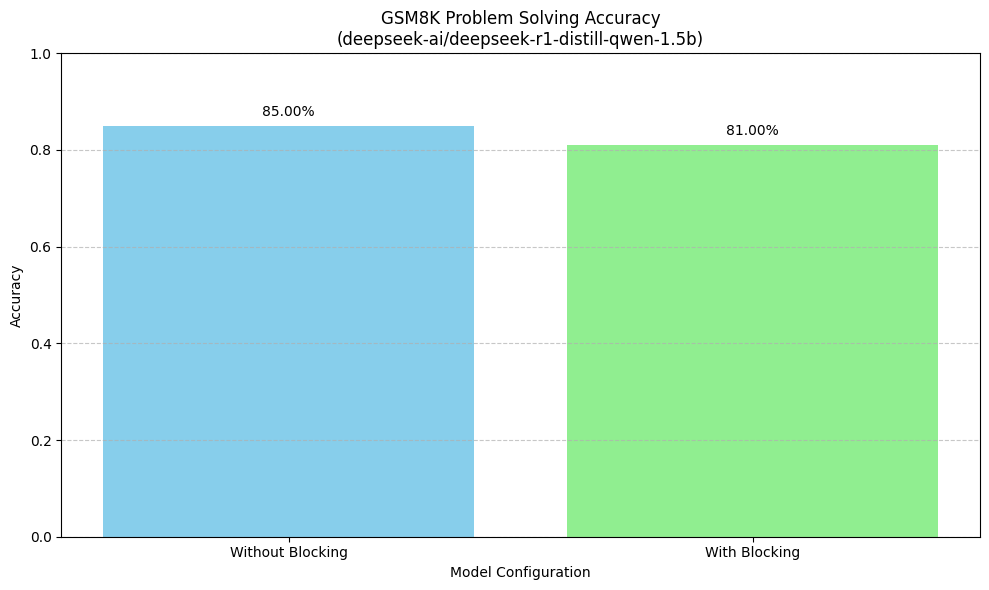

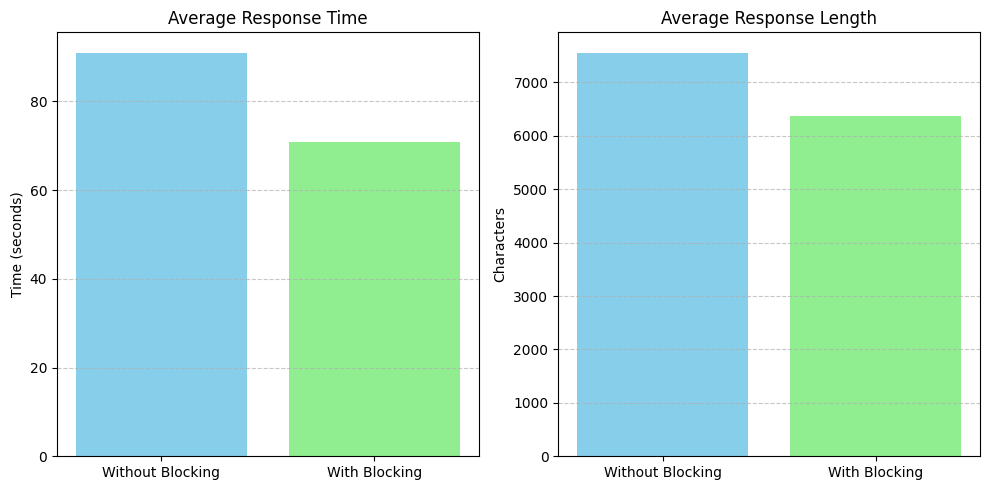

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.



All results saved to: /content/drive/MyDrive/llm_eval_results/token_blocking_benchmark_deepeval/run_20250321_023511

===== Simple Token Blocking Test =====
Without blocking:


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


 I'm trying to find the number of positive integers n ≤ X such that n! is divisible by n^k, where k is a positive integer. Hmm, okay, let's see.
To start, I need to understand what the problem is asking. I need to find the number of positive integers n ≤ X such that n! is divisible by n^k. Hmm, so n! is divisible by n^k, which means that n^k divides n!. That is, n^k | n!. So, we can write this as n^k divides n factorial. So, for each n, I need to check whether n^k divides n!, and then count the number of such n's that satisfy this condition.

But wait, n is a positive integer less than or equal to X, so for each n from 1 to X, I need to check whether n^k divides n!. But that seems computationally intensive if X is large because factorials can get very big, and checking divisibility for each n might be time-consuming.

Alternatively, maybe there's a mathematical approach or formula to compute this without checking each n individually. Let me think about the properties of factorials and 

In [ ]:
# Install required packages
!pip install -q transformers torch matplotlib pandas tqdm accelerate deepeval datasets

import time, os, json, gc, torch, hashlib
from datetime import datetime
from threading import Thread
import matplotlib.pyplot as plt
import pandas as pd
from transformers import AutoTokenizer, AutoModelForCausalLM, TextIteratorStreamer
from typing import List

# Import DeepEval components
from deepeval import evaluate
from deepeval.metrics import HallucinationMetric, AnswerRelevancyMetric, ContextualRecallMetric
from deepeval.test_case import LLMTestCase
from deepeval.dataset import EvaluationDataset
from deepeval.models.base_model import DeepEvalBaseLLM

# --- Token Blocking Helper Functions and Classes ---

def get_blocked_token_ids(tokenizer, words):
    """Get unique token IDs for the given words in various cases."""
    blocked_ids = []
    for word in words:
        for form in [(" " + word), word,
                     (" " + word.capitalize()), word.capitalize(),
                     (" " + word.upper()), word.upper()]:
            blocked_ids.extend(tokenizer.encode(form, add_special_tokens=False))
    unique_ids = list(set(blocked_ids))
    print(f"\nBlocking these words: {words}")
    print(f"Corresponding to these {len(unique_ids)} token IDs: {unique_ids}")
    for token_id in unique_ids:
        print(f"Token ID {token_id} = '{tokenizer.decode([token_id])}'")
    return unique_ids

class TokenBlockLogitsProcessor:
    """A logits processor that sets scores for specified token IDs to -inf."""
    def __init__(self, blocked_token_ids):
        self.blocked_token_ids = blocked_token_ids

    def __call__(self, input_ids, scores):
        mask = torch.zeros_like(scores, dtype=torch.bool)
        mask[:, self.blocked_token_ids] = True
        return scores.masked_fill(mask, float('-inf'))

# --- Custom DeepEval Model With Token Blocking ---
class TokenBlockingLLM(DeepEvalBaseLLM):
    """
    A DeepEval-compatible LLM implementation with token blocking functionality.
    """
    def __init__(
        self,
        model,
        tokenizer,
        blocked_token_ids=None,
        temperature=0.7,
        top_p=0.9,
        top_k=40,
        max_tokens=512,
        model_name="DeepSeek-R1-Distill"
    ):
        self.model = model
        self.tokenizer = tokenizer
        self.blocked_token_ids = blocked_token_ids
        self.temperature = temperature
        self.top_p = top_p
        self.top_k = top_k
        self.max_tokens = max_tokens
        self._model_name = model_name
        self.generation_stats = []

    def load_model(self):
        return self.model

    def generate(self, prompt: str) -> str:
        start_time = time.time()
        model = self.load_model()

        inputs = self.tokenizer(
            prompt,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=5000,
        ).to(model.device)

        logits_processors = []
        if self.blocked_token_ids is not None:
            logits_processors.append(TokenBlockLogitsProcessor(self.blocked_token_ids))

        streamer = TextIteratorStreamer(self.tokenizer, skip_special_tokens=True, skip_prompt=True)
        generation_kwargs = dict(
            **inputs,
            max_new_tokens=self.max_tokens,
            temperature=self.temperature,
            top_p=self.top_p,
            top_k=self.top_k,
            do_sample=True,
            streamer=streamer,
            return_dict_in_generate=True,
            output_scores=True,
            logits_processor=logits_processors if logits_processors else None
        )

        # Run generation in a separate thread to stream output token-by-token.
        thread = Thread(target=model.generate, kwargs=generation_kwargs)
        thread.start()

        generated_text = ""
        for new_text in streamer:
            generated_text += new_text

        generation_time = time.time() - start_time
        self.generation_stats.append({
            'time': generation_time,
            'length': len(generated_text)
        })

        return generated_text

    async def a_generate(self, prompt: str) -> str:
        """Async generate implementation required by DeepEval"""
        return self.generate(prompt)

    def batch_generate(self, prompts: List[str]) -> List[str]:
        """Batch generation implementation for DeepEval"""
        return [self.generate(prompt) for prompt in prompts]

    def get_model_name(self):
        """Return model name for DeepEval reporting"""
        blocking_status = "with_blocking" if self.blocked_token_ids is not None else "no_blocking"
        return f"{self._model_name}_{blocking_status}"

    def get_avg_stats(self):
        """Get average statistics from generation runs"""
        if not self.generation_stats:
            return {'avg_time': 0, 'avg_length': 0}

        avg_time = sum(stat['time'] for stat in self.generation_stats) / len(self.generation_stats)
        avg_length = sum(stat['length'] for stat in self.generation_stats) / len(self.generation_stats)

        return {'avg_time': avg_time, 'avg_length': avg_length}

# --- Experiment Setup and Running Benchmark ---

# Create directories for results
base_dir = "/content/drive/MyDrive/llm_eval_results"  # Adjust based on your environment
results_dir = os.path.join(base_dir, "token_blocking_benchmark_deepeval")
os.makedirs(results_dir, exist_ok=True)
print(f"Results will be saved to: {results_dir}")

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
run_dir = os.path.join(results_dir, f"run_{timestamp}")
os.makedirs(run_dir, exist_ok=True)

# Define words to block
words_to_block = ["wait", "alternatively", "perhaps", "maybe"]

# Load model and tokenizer (using DeepSeek-R1-Distill-Qwen-1.5B as in original code)
print("Loading model...")
model_name = "deepseek-ai/deepseek-r1-distill-qwen-1.5b"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="auto"
)

# Get blocked token IDs
blocked_ids = get_blocked_token_ids(tokenizer, words_to_block)
blocked_token_ids = torch.tensor(blocked_ids, device=model.device)

# Create two model instances: one without and one with token blocking
llm_unblocked = TokenBlockingLLM(
    model=model,
    tokenizer=tokenizer,
    blocked_token_ids=None,
    temperature=0.7,
    top_p=0.9,
    top_k=40,
    max_tokens=5120
)

llm_blocked = TokenBlockingLLM(
    model=model,
    tokenizer=tokenizer,
    blocked_token_ids=blocked_token_ids,
    temperature=0.7,
    top_p=0.9,
    top_k=40,
    max_tokens=5120
)

# --- Create test dataset with GSM8K problems ---
from datasets import load_dataset

def create_test_cases_from_gsm8k(num_samples=100):
    """Create DeepEval test cases from GSM8K dataset"""
    dataset = load_dataset("gsm8k", "main", split="test")
    dataset = dataset.shuffle(seed=42).select(range(min(num_samples, len(dataset))))

    test_cases = []
    for idx, item in enumerate(dataset):
        question = item["question"]
        answer = item["answer"]

        # Extract just the final numeric answer from the GSM8K answer format
        final_answer = answer.split("####")[-1].strip()

        # Convert context to a list of strings as required by LLMTestCase
        context_list = [answer] if answer else None

        test_case = LLMTestCase(
            input=f"Solve this math problem step by step: {question}",
            actual_output="",  # Will be filled during evaluation
            expected_output=final_answer,
            context=context_list  # Context must be a list of strings
        )
        test_cases.append(test_case)

    return test_cases

# Removed fallback test cases function as requested

# Create an evaluation dataset
print("Creating evaluation dataset from GSM8K benchmark...")
# You can adjust the number of samples as needed for your experiment
test_cases = create_test_cases_from_gsm8k(num_samples=100)
evaluation_dataset = EvaluationDataset(test_cases=test_cases)

# --- Custom Metrics for Direct Answer Evaluation ---
class MathProblemAccuracyEvaluator:
    """
    Simple evaluator that checks if the model's answer contains the correct answer.
    No OpenAI API or external services required.
    """
    def __init__(self):
        self.correct_count = 0
        self.total_count = 0
        self.results = []

    def evaluate(self, model, test_cases):
        print(f"Evaluating {len(test_cases)} problems...")
        self.correct_count = 0
        self.total_count = 0
        self.results = []

        for i, test_case in enumerate(test_cases):
            print(f"Problem {i+1}/{len(test_cases)}", end="\r")
            prompt = test_case.input
            expected = test_case.expected_output.strip()

            # Generate answer using the model
            model_answer = model.generate(prompt)

            # Simple exact match check - could be improved for more robust checking
            contains_answer = expected in model_answer

            # Track results
            result = {
                "prompt": prompt,
                "expected": expected,
                "model_answer": model_answer,
                "is_correct": contains_answer
            }

            self.results.append(result)

            if contains_answer:
                self.correct_count += 1
            self.total_count += 1

        accuracy = self.correct_count / self.total_count if self.total_count > 0 else 0
        print(f"\nEvaluation complete. Accuracy: {accuracy:.2%}")

        return {
            "accuracy": accuracy,
            "correct_count": self.correct_count,
            "total_count": self.total_count,
            "detailed_results": self.results
        }

# --- Run evaluations ---
print("\n===== Running evaluation WITHOUT token blocking =====")
evaluator = MathProblemAccuracyEvaluator()
unblocked_results = evaluator.evaluate(
    model=llm_unblocked,
    test_cases=test_cases
)

# Clean up memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    gc.collect()

print("\n===== Running evaluation WITH token blocking =====")
evaluator = MathProblemAccuracyEvaluator()
blocked_results = evaluator.evaluate(
    model=llm_blocked,
    test_cases=test_cases
)

# --- Collect and analyze results ---
unblocked_stats = llm_unblocked.get_avg_stats()
blocked_stats = llm_blocked.get_avg_stats()

# Create result summary
summary = {
    'model': model_name,
    'timestamp': timestamp,
    'words_blocked': words_to_block,
    'unblocked': {
        'accuracy': unblocked_results['accuracy'],
        'correct_count': unblocked_results['correct_count'],
        'total_count': unblocked_results['total_count'],
        'avg_response_time': unblocked_stats['avg_time'],
        'avg_response_length': unblocked_stats['avg_length']
    },
    'blocked': {
        'accuracy': blocked_results['accuracy'],
        'correct_count': blocked_results['correct_count'],
        'total_count': blocked_results['total_count'],
        'avg_response_time': blocked_stats['avg_time'],
        'avg_response_length': blocked_stats['avg_length']
    }
}

# Save summary to file
summary_filepath = os.path.join(run_dir, f"summary_{timestamp}.json")
with open(summary_filepath, 'w') as f:
    json.dump(summary, f, indent=2)

# Save detailed results for further analysis
detailed_results_filepath = os.path.join(run_dir, f"detailed_results_{timestamp}.json")
with open(detailed_results_filepath, 'w') as f:
    json.dump({
        "unblocked_results": unblocked_results["detailed_results"],
        "blocked_results": blocked_results["detailed_results"]
    }, f, indent=2)

# Create comparison dataframe
comparison_data = [
    {
        'Metric': 'Accuracy',
        'Without Blocking': summary['unblocked']['accuracy'],
        'With Blocking': summary['blocked']['accuracy'],
        'Difference': summary['blocked']['accuracy'] - summary['unblocked']['accuracy']
    },
    {
        'Metric': 'Avg Response Time (s)',
        'Without Blocking': summary['unblocked']['avg_response_time'],
        'With Blocking': summary['blocked']['avg_response_time'],
        'Difference': summary['blocked']['avg_response_time'] - summary['unblocked']['avg_response_time']
    },
    {
        'Metric': 'Avg Response Length',
        'Without Blocking': summary['unblocked']['avg_response_length'],
        'With Blocking': summary['blocked']['avg_response_length'],
        'Difference': summary['blocked']['avg_response_length'] - summary['unblocked']['avg_response_length']
    }
]

df_comparison = pd.DataFrame(comparison_data)
print("\n===== Final Results =====")
print(df_comparison)

# Save comparison to CSV
df_comparison.to_csv(os.path.join(run_dir, f"comparison_{timestamp}.csv"), index=False)

# Visualization
plt.figure(figsize=(10, 6))
plt.bar(['Without Blocking', 'With Blocking'],
        [summary['unblocked']['accuracy'], summary['blocked']['accuracy']],
        color=['skyblue', 'lightgreen'])
plt.xlabel('Model Configuration')
plt.ylabel('Accuracy')
plt.title(f'GSM8K Problem Solving Accuracy\n({model_name})')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add accuracy values on top of bars
for i, v in enumerate([summary['unblocked']['accuracy'], summary['blocked']['accuracy']]):
    plt.text(i, v + 0.02, f"{v:.2%}", ha='center')

plt.tight_layout()
plt.savefig(os.path.join(run_dir, f"accuracy_comparison_{timestamp}.png"))
plt.show()

# Additional visualization for response time and length
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(['Without Blocking', 'With Blocking'],
        [summary['unblocked']['avg_response_time'], summary['blocked']['avg_response_time']],
        color=['skyblue', 'lightgreen'])
plt.title('Average Response Time')
plt.ylabel('Time (seconds)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.subplot(1, 2, 2)
plt.bar(['Without Blocking', 'With Blocking'],
        [summary['unblocked']['avg_response_length'], summary['blocked']['avg_response_length']],
        color=['skyblue', 'lightgreen'])
plt.title('Average Response Length')
plt.ylabel('Characters')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig(os.path.join(run_dir, f"performance_comparison_{timestamp}.png"))
plt.show()

print(f"\nAll results saved to: {run_dir}")

# --- Optional: Run a simple test to verify token blocking works ---
def test_token_blocking():
    print("\n===== Simple Token Blocking Test =====")
    test_prompt = "What approach should I take to solve this problem?"

    print("Without blocking:")
    unblocked_response = llm_unblocked.generate(test_prompt)
    print(unblocked_response)

    print("\nWith blocking:")
    blocked_response = llm_blocked.generate(test_prompt)
    print(blocked_response)

    # Count occurrences of blocked words
    blocked_word_counts_unblocked = {word: unblocked_response.lower().count(word.lower()) for word in words_to_block}
    blocked_word_counts_blocked = {word: blocked_response.lower().count(word.lower()) for word in words_to_block}

    print("\nBlocked word counts in unblocked response:")
    print(blocked_word_counts_unblocked)

    print("\nBlocked word counts in blocked response:")
    print(blocked_word_counts_blocked)

# Run the test at the end
test_token_blocking()

In [ ]:
import torch
torch.cuda.empty_cache()
import gc
gc.collect()


In [ ]:
# Install required packages
!pip install -q transformers torch matplotlib pandas tqdm accelerate deepeval

import time, os, json, gc, torch, hashlib
from datetime import datetime
from threading import Thread
import matplotlib.pyplot as plt
import pandas as pd
from transformers import AutoTokenizer, AutoModelForCausalLM, TextIteratorStreamer
from typing import List

# Import DeepEval components
from deepeval import evaluate
from deepeval.metrics import HallucinationMetric, AnswerRelevancyMetric, ContextualRecallMetric
from deepeval.test_case import LLMTestCase
from deepeval.dataset import EvaluationDataset
from deepeval.models.base_model import DeepEvalBaseLLM

# --- Token Blocking Helper Functions and Classes ---

def get_blocked_token_ids(tokenizer, words):
    """Get unique token IDs for the given words in various cases."""
    blocked_ids = []
    for word in words:
        for form in [(" " + word), word,
                     (" " + word.capitalize()), word.capitalize(),
                     (" " + word.upper()), word.upper()]:
            blocked_ids.extend(tokenizer.encode(form, add_special_tokens=False))
    unique_ids = list(set(blocked_ids))
    print(f"\nBlocking these words: {words}")
    print(f"Corresponding to these {len(unique_ids)} token IDs: {unique_ids}")
    for token_id in unique_ids:
        print(f"Token ID {token_id} = '{tokenizer.decode([token_id])}'")
    return unique_ids

class TokenBlockLogitsProcessor:
    """A logits processor that sets scores for specified token IDs to -inf."""
    def __init__(self, blocked_token_ids):
        self.blocked_token_ids = blocked_token_ids

    def __call__(self, input_ids, scores):
        mask = torch.zeros_like(scores, dtype=torch.bool)
        mask[:, self.blocked_token_ids] = True
        return scores.masked_fill(mask, float('-inf'))

# --- Custom DeepEval Model With Token Blocking ---
class TokenBlockingLLM(DeepEvalBaseLLM):
    """
    A DeepEval-compatible LLM implementation with token blocking functionality.
    """
    def __init__(
        self,
        model,
        tokenizer,
        blocked_token_ids=None,
        temperature=0.7,
        top_p=0.9,
        top_k=40,
        max_tokens=512,
        model_name="DeepSeek-R1-Distill"
    ):
        self.model = model
        self.tokenizer = tokenizer
        self.blocked_token_ids = blocked_token_ids
        self.temperature = temperature
        self.top_p = top_p
        self.top_k = top_k
        self.max_tokens = max_tokens
        self._model_name = model_name
        self.generation_stats = []

    def load_model(self):
        return self.model

    def generate(self, prompt: str) -> str:
        start_time = time.time()
        model = self.load_model()

        inputs = self.tokenizer(
            prompt,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=5000,
        ).to(model.device)

        logits_processors = []
        if self.blocked_token_ids is not None:
            logits_processors.append(TokenBlockLogitsProcessor(self.blocked_token_ids))

        streamer = TextIteratorStreamer(self.tokenizer, skip_special_tokens=True, skip_prompt=True)
        generation_kwargs = dict(
            **inputs,
            max_new_tokens=self.max_tokens,
            temperature=self.temperature,
            top_p=self.top_p,
            top_k=self.top_k,
            do_sample=True,
            streamer=streamer,
            return_dict_in_generate=True,
            output_scores=True,
            logits_processor=logits_processors if logits_processors else None
        )

        # Run generation in a separate thread to stream output token-by-token.
        thread = Thread(target=model.generate, kwargs=generation_kwargs)
        thread.start()

        generated_text = ""
        for new_text in streamer:
            generated_text += new_text

        generation_time = time.time() - start_time
        self.generation_stats.append({
            'time': generation_time,
            'length': len(generated_text)
        })

        return generated_text

    async def a_generate(self, prompt: str) -> str:
        """Async generate implementation required by DeepEval"""
        return self.generate(prompt)

    def batch_generate(self, prompts: List[str]) -> List[str]:
        """Batch generation implementation for DeepEval"""
        return [self.generate(prompt) for prompt in prompts]

    def get_model_name(self):
        """Return model name for DeepEval reporting"""
        blocking_status = "with_blocking" if self.blocked_token_ids is not None else "no_blocking"
        return f"{self._model_name}_{blocking_status}"

    def get_avg_stats(self):
        """Get average statistics from generation runs"""
        if not self.generation_stats:
            return {'avg_time': 0, 'avg_length': 0}

        avg_time = sum(stat['time'] for stat in self.generation_stats) / len(self.generation_stats)
        avg_length = sum(stat['length'] for stat in self.generation_stats) / len(self.generation_stats)

        return {'avg_time': avg_time, 'avg_length': avg_length}

# --- Experiment Setup and Running Benchmark ---

# Create directories for results
base_dir = "/content/drive/MyDrive/llm_eval_results"  # Adjust based on your environment
results_dir = os.path.join(base_dir, "token_blocking_benchmark_deepeval")
os.makedirs(results_dir, exist_ok=True)
print(f"Results will be saved to: {results_dir}")

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
run_dir = os.path.join(results_dir, f"run_{timestamp}")
os.makedirs(run_dir, exist_ok=True)

# Define words to block
words_to_block = ["wait", "alternatively", "perhaps", "maybe"]

# Load model and tokenizer (using DeepSeek-R1-Distill-Qwen-1.5B as in original code)
print("Loading model...")
model_name = "deepseek-ai/deepseek-r1-distill-qwen-1.5b"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="auto"
)

# Get blocked token IDs
blocked_ids = get_blocked_token_ids(tokenizer, words_to_block)
blocked_token_ids = torch.tensor(blocked_ids, device=model.device)

# Create two model instances: one without and one with token blocking
llm_unblocked = TokenBlockingLLM(
    model=model,
    tokenizer=tokenizer,
    blocked_token_ids=None,
    temperature=0.7,
    top_p=0.9,
    top_k=40,
    max_tokens=5120
)

llm_blocked = TokenBlockingLLM(
    model=model,
    tokenizer=tokenizer,
    blocked_token_ids=blocked_token_ids,
    temperature=0.7,
    top_p=0.9,
    top_k=40,
    max_tokens=5120
)

# --- Create test dataset with GSM8K problems ---
from datasets import load_dataset

def create_test_cases_from_gsm8k(num_samples=8000):
    """Create DeepEval test cases from GSM8K dataset"""
    dataset = load_dataset("gsm8k", "main", split="test")
    dataset = dataset.shuffle(seed=42).select(range(min(num_samples, len(dataset))))

    test_cases = []
    for idx, item in enumerate(dataset):
        question = item["question"]
        answer = item["answer"]

        # Extract just the final numeric answer from the GSM8K answer format
        final_answer = answer.split("####")[-1].strip()

        # Convert context to a list of strings as required by LLMTestCase
        context_list = [answer] if answer else None

        test_case = LLMTestCase(
            input=f"Solve this math problem step by step: {question}",
            actual_output="",  # Will be filled during evaluation
            expected_output=final_answer,
            context=context_list  # Context must be a list of strings
        )
        test_cases.append(test_case)

    return test_cases

# Removed fallback test cases function as requested

# Create an evaluation dataset
print("Creating evaluation dataset from GSM8K benchmark...")
# You can adjust the number of samples as needed for your experiment
test_cases = create_test_cases_from_gsm8k(num_samples=8000)
evaluation_dataset = EvaluationDataset(test_cases=test_cases)

# --- Custom Metrics for Direct Answer Evaluation ---
class MathProblemAccuracyEvaluator:
    """
    Simple evaluator that checks if the model's answer contains the correct answer.
    No OpenAI API or external services required.
    """
    def __init__(self):
        self.correct_count = 0
        self.total_count = 0
        self.results = []

    def evaluate(self, model, test_cases):
        print(f"Evaluating {len(test_cases)} problems...")
        self.correct_count = 0
        self.total_count = 0
        self.results = []

        for i, test_case in enumerate(test_cases):
            print(f"Problem {i+1}/{len(test_cases)}", end="\r")
            prompt = test_case.input
            expected = test_case.expected_output.strip()

            # Generate answer using the model
            model_answer = model.generate(prompt)

            # Simple exact match check - could be improved for more robust checking
            contains_answer = expected in model_answer

            # Track results
            result = {
                "prompt": prompt,
                "expected": expected,
                "model_answer": model_answer,
                "is_correct": contains_answer
            }

            self.results.append(result)

            if contains_answer:
                self.correct_count += 1
            self.total_count += 1

        accuracy = self.correct_count / self.total_count if self.total_count > 0 else 0
        print(f"\nEvaluation complete. Accuracy: {accuracy:.2%}")

        return {
            "accuracy": accuracy,
            "correct_count": self.correct_count,
            "total_count": self.total_count,
            "detailed_results": self.results
        }

# --- Run evaluations ---
print("\n===== Running evaluation WITHOUT token blocking =====")
evaluator = MathProblemAccuracyEvaluator()
unblocked_results = evaluator.evaluate(
    model=llm_unblocked,
    test_cases=test_cases
)

# Clean up memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    gc.collect()

print("\n===== Running evaluation WITH token blocking =====")
evaluator = MathProblemAccuracyEvaluator()
blocked_results = evaluator.evaluate(
    model=llm_blocked,
    test_cases=test_cases
)

# --- Collect and analyze results ---
unblocked_stats = llm_unblocked.get_avg_stats()
blocked_stats = llm_blocked.get_avg_stats()

# Create result summary
summary = {
    'model': model_name,
    'timestamp': timestamp,
    'words_blocked': words_to_block,
    'unblocked': {
        'accuracy': unblocked_results['accuracy'],
        'correct_count': unblocked_results['correct_count'],
        'total_count': unblocked_results['total_count'],
        'avg_response_time': unblocked_stats['avg_time'],
        'avg_response_length': unblocked_stats['avg_length']
    },
    'blocked': {
        'accuracy': blocked_results['accuracy'],
        'correct_count': blocked_results['correct_count'],
        'total_count': blocked_results['total_count'],
        'avg_response_time': blocked_stats['avg_time'],
        'avg_response_length': blocked_stats['avg_length']
    }
}

# Save summary to file
summary_filepath = os.path.join(run_dir, f"summary_{timestamp}.json")
with open(summary_filepath, 'w') as f:
    json.dump(summary, f, indent=2)

# Save detailed results for further analysis
detailed_results_filepath = os.path.join(run_dir, f"detailed_results_{timestamp}.json")
with open(detailed_results_filepath, 'w') as f:
    json.dump({
        "unblocked_results": unblocked_results["detailed_results"],
        "blocked_results": blocked_results["detailed_results"]
    }, f, indent=2)

# Create comparison dataframe
comparison_data = [
    {
        'Metric': 'Accuracy',
        'Without Blocking': summary['unblocked']['accuracy'],
        'With Blocking': summary['blocked']['accuracy'],
        'Difference': summary['blocked']['accuracy'] - summary['unblocked']['accuracy']
    },
    {
        'Metric': 'Avg Response Time (s)',
        'Without Blocking': summary['unblocked']['avg_response_time'],
        'With Blocking': summary['blocked']['avg_response_time'],
        'Difference': summary['blocked']['avg_response_time'] - summary['unblocked']['avg_response_time']
    },
    {
        'Metric': 'Avg Response Length',
        'Without Blocking': summary['unblocked']['avg_response_length'],
        'With Blocking': summary['blocked']['avg_response_length'],
        'Difference': summary['blocked']['avg_response_length'] - summary['unblocked']['avg_response_length']
    }
]

df_comparison = pd.DataFrame(comparison_data)
print("\n===== Final Results =====")
print(df_comparison)

# Save comparison to CSV
df_comparison.to_csv(os.path.join(run_dir, f"comparison_{timestamp}.csv"), index=False)

# Visualization
plt.figure(figsize=(10, 6))
plt.bar(['Without Blocking', 'With Blocking'],
        [summary['unblocked']['accuracy'], summary['blocked']['accuracy']],
        color=['skyblue', 'lightgreen'])
plt.xlabel('Model Configuration')
plt.ylabel('Accuracy')
plt.title(f'GSM8K Problem Solving Accuracy\n({model_name})')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add accuracy values on top of bars
for i, v in enumerate([summary['unblocked']['accuracy'], summary['blocked']['accuracy']]):
    plt.text(i, v + 0.02, f"{v:.2%}", ha='center')

plt.tight_layout()
plt.savefig(os.path.join(run_dir, f"accuracy_comparison_{timestamp}.png"))
plt.show()

# Additional visualization for response time and length
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(['Without Blocking', 'With Blocking'],
        [summary['unblocked']['avg_response_time'], summary['blocked']['avg_response_time']],
        color=['skyblue', 'lightgreen'])
plt.title('Average Response Time')
plt.ylabel('Time (seconds)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.subplot(1, 2, 2)
plt.bar(['Without Blocking', 'With Blocking'],
        [summary['unblocked']['avg_response_length'], summary['blocked']['avg_response_length']],
        color=['skyblue', 'lightgreen'])
plt.title('Average Response Length')
plt.ylabel('Characters')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig(os.path.join(run_dir, f"performance_comparison_{timestamp}.png"))
plt.show()

print(f"\nAll results saved to: {run_dir}")

# --- Optional: Run a simple test to verify token blocking works ---
def test_token_blocking():
    print("\n===== Simple Token Blocking Test =====")
    test_prompt = "What approach should I take to solve this problem?"

    print("Without blocking:")
    unblocked_response = llm_unblocked.generate(test_prompt)
    print(unblocked_response)

    print("\nWith blocking:")
    blocked_response = llm_blocked.generate(test_prompt)
    print(blocked_response)

    # Count occurrences of blocked words
    blocked_word_counts_unblocked = {word: unblocked_response.lower().count(word.lower()) for word in words_to_block}
    blocked_word_counts_blocked = {word: blocked_response.lower().count(word.lower()) for word in words_to_block}

    print("\nBlocked word counts in unblocked response:")
    print(blocked_word_counts_unblocked)

    print("\nBlocked word counts in blocked response:")
    print(blocked_word_counts_blocked)

# Run the test at the end
test_token_blocking()

test of 10

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 99.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.5/571.5 kB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/3.07k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/679 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.55G [00:00<?, ?B/s]

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]


Blocking these words: ['wait', 'alternatively', 'perhaps', 'maybe']
Corresponding to these 33 token IDs: [13824, 71032, 21390, 3090, 36760, 7196, 68387, 39, 44, 8365, 8753, 9654, 49209, 828, 17854, 39230, 3783, 10696, 969, 47945, 11594, 18765, 38478, 7887, 3022, 40412, 11489, 14190, 92014, 31476, 54390, 65272, 10877]
Token ID 13824 = ' Wait'
Token ID 71032 = 'WAIT'
Token ID 21390 = 'Maybe'
Token ID 3090 = 'IV'
Token ID 36760 = 'maybe'
Token ID 7196 = ' maybe'
Token ID 68387 = ' alternatively'
Token ID 39 = 'H'
Token ID 44 = 'M'
Token ID 8365 = ' perhaps'
Token ID 8753 = ' AL'
Token ID 9654 = 'PER'
Token ID 49209 = 'ELY'
Token ID 828 = 'AT'
Token ID 17854 = ' PER'
Token ID 39230 = ' MAY'
Token ID 3783 = ' wait'
Token ID 10696 = ' Maybe'
Token ID 969 = 'AL'
Token ID 47945 = 'APS'
Token ID 11594 = 'BE'
Token ID 18765 = ' Perhaps'
Token ID 38478 = ' Alternatively'
Token ID 7887 = 'atively'
Token ID 3022 = 'AY'
Token ID 40412 = 'altern'
Token ID 11489 = 'wait'
Token ID 14190 = 'Wait'
Token

README.md:   0%|          | 0.00/7.94k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/419k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.



===== Running evaluation WITHOUT token blocking =====
Evaluating 10 problems...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Problem 10/10
Evaluation complete. Accuracy: 70.00%


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.



===== Running evaluation WITH token blocking =====
Evaluating 10 problems...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Problem 10/10
Evaluation complete. Accuracy: 80.00%

===== Final Results =====
                  Metric  Without Blocking  With Blocking   Difference
0               Accuracy          0.700000        0.80000     0.100000
1  Avg Response Time (s)         91.730564       61.82886   -29.901704
2    Avg Response Length       8833.000000     6256.60000 -2576.400000


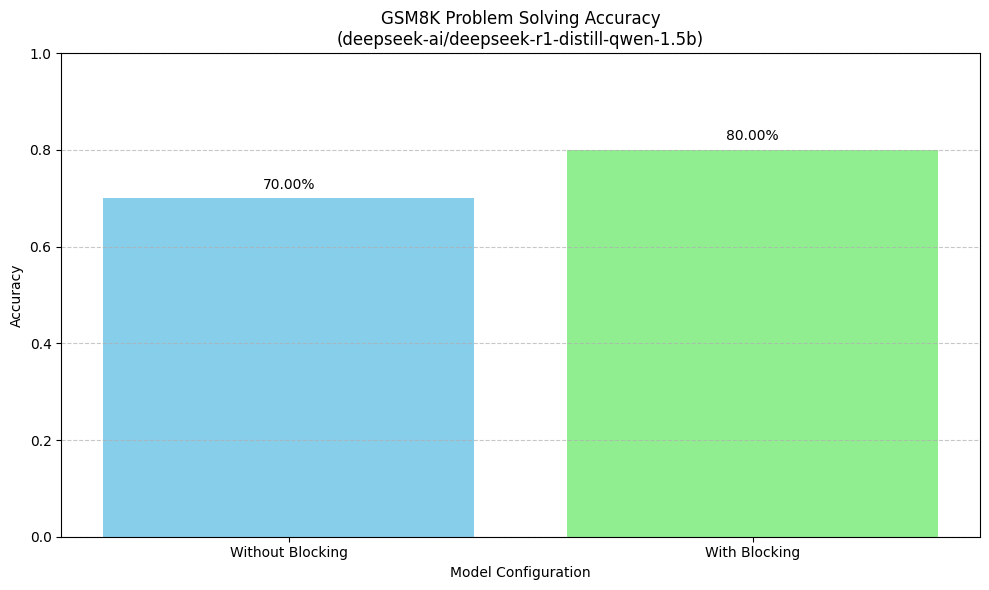

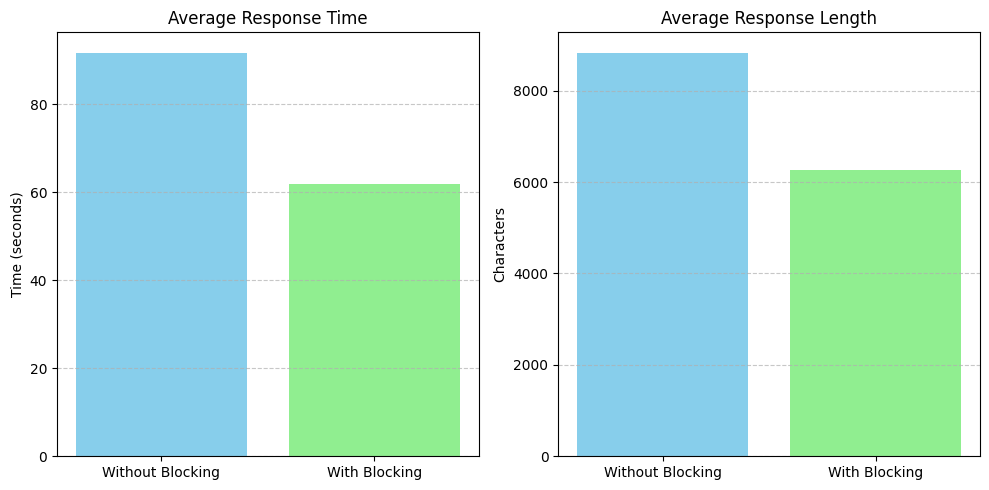

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.



All results saved to: /content/drive/MyDrive/llm_eval_results/token_blocking_benchmark_deepeval/run_20250321_155334

===== Simple Token Blocking Test =====
Without blocking:


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


 Let me explain the problem.

I have a binary matrix, which is n x m. Each element is 0 or 1. I need to find the maximum sum of a submatrix, where the sum is defined as the number of 1s in that submatrix. So, the submatrix is a contiguous block of elements. It's given that n and m can be up to 1e5, and the sum of n and m can be up to 1e5. So, the approach should be efficient.

I have to write a Python code that implements this.

First, I need to think about the approach. Let's consider the problem of finding the maximum sum of a submatrix in a binary matrix. The standard approach for this is to use the sliding window technique, which allows us to compute the sum in O(1) time after some initial preprocessing.

But in this problem, the matrix can be as large as 1e5 x 1e5, which makes it impossible to compute the sum for every possible submatrix. So, the solution needs to find an approach that can compute the maximum sum efficiently, without checking every possible submatrix.

Wait, the p

In [ ]:
# Mount Google Drive (for Colab)
from google.colab import drive
drive.mount('/content/drive')

!pip install -q transformers torch matplotlib pandas tqdm accelerate deepeval datasets

import time, os, json, gc, torch, hashlib
from datetime import datetime
from threading import Thread
import matplotlib.pyplot as plt
import pandas as pd
from transformers import AutoTokenizer, AutoModelForCausalLM, TextIteratorStreamer
from typing import List

# Import DeepEval components
from deepeval import evaluate
from deepeval.metrics import HallucinationMetric, AnswerRelevancyMetric, ContextualRecallMetric
from deepeval.test_case import LLMTestCase
from deepeval.dataset import EvaluationDataset
from deepeval.models.base_model import DeepEvalBaseLLM

# --- Token Blocking Helper Functions and Classes ---

def get_blocked_token_ids(tokenizer, words):
    """Get unique token IDs for the given words in various cases."""
    blocked_ids = []
    for word in words:
        for form in [(" " + word), word,
                     (" " + word.capitalize()), word.capitalize(),
                     (" " + word.upper()), word.upper()]:
            blocked_ids.extend(tokenizer.encode(form, add_special_tokens=False))
    unique_ids = list(set(blocked_ids))
    print(f"\nBlocking these words: {words}")
    print(f"Corresponding to these {len(unique_ids)} token IDs: {unique_ids}")
    for token_id in unique_ids:
        print(f"Token ID {token_id} = '{tokenizer.decode([token_id])}'")
    return unique_ids

class TokenBlockLogitsProcessor:
    """A logits processor that sets scores for specified token IDs to -inf."""
    def __init__(self, blocked_token_ids):
        self.blocked_token_ids = blocked_token_ids

    def __call__(self, input_ids, scores):
        mask = torch.zeros_like(scores, dtype=torch.bool)
        mask[:, self.blocked_token_ids] = True
        return scores.masked_fill(mask, float('-inf'))

# --- Custom DeepEval Model With Token Blocking ---
class TokenBlockingLLM(DeepEvalBaseLLM):
    """
    A DeepEval-compatible LLM implementation with token blocking functionality.
    """
    def __init__(
        self,
        model,
        tokenizer,
        blocked_token_ids=None,
        temperature=0.7,
        top_p=0.9,
        top_k=40,
        max_tokens=512,
        model_name="DeepSeek-R1-Distill"
    ):
        self.model = model
        self.tokenizer = tokenizer
        self.blocked_token_ids = blocked_token_ids
        self.temperature = temperature
        self.top_p = top_p
        self.top_k = top_k
        self.max_tokens = max_tokens
        self._model_name = model_name
        self.generation_stats = []

    def load_model(self):
        return self.model

    def generate(self, prompt: str) -> str:
        start_time = time.time()
        model = self.load_model()

        inputs = self.tokenizer(
            prompt,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=5000,
        ).to(model.device)

        logits_processors = []
        if self.blocked_token_ids is not None:
            logits_processors.append(TokenBlockLogitsProcessor(self.blocked_token_ids))

        streamer = TextIteratorStreamer(self.tokenizer, skip_special_tokens=True, skip_prompt=True)
        generation_kwargs = dict(
            **inputs,
            max_new_tokens=self.max_tokens,
            temperature=self.temperature,
            top_p=self.top_p,
            top_k=self.top_k,
            do_sample=True,
            streamer=streamer,
            return_dict_in_generate=True,
            output_scores=True,
            logits_processor=logits_processors if logits_processors else None
        )

        # Run generation in a separate thread to stream output token-by-token.
        thread = Thread(target=model.generate, kwargs=generation_kwargs)
        thread.start()

        generated_text = ""
        for new_text in streamer:
            generated_text += new_text

        generation_time = time.time() - start_time
        self.generation_stats.append({
            'time': generation_time,
            'length': len(generated_text)
        })

        return generated_text

    async def a_generate(self, prompt: str) -> str:
        """Async generate implementation required by DeepEval"""
        return self.generate(prompt)

    def batch_generate(self, prompts: List[str]) -> List[str]:
        """Batch generation implementation for DeepEval"""
        return [self.generate(prompt) for prompt in prompts]

    def get_model_name(self):
        """Return model name for DeepEval reporting"""
        blocking_status = "with_blocking" if self.blocked_token_ids is not None else "no_blocking"
        return f"{self._model_name}_{blocking_status}"

    def get_avg_stats(self):
        """Get average statistics from generation runs"""
        if not self.generation_stats:
            return {'avg_time': 0, 'avg_length': 0}

        avg_time = sum(stat['time'] for stat in self.generation_stats) / len(self.generation_stats)
        avg_length = sum(stat['length'] for stat in self.generation_stats) / len(self.generation_stats)

        return {'avg_time': avg_time, 'avg_length': avg_length}

# --- Experiment Setup and Running Benchmark ---

# Create directories for results
base_dir = "/content/drive/MyDrive/llm_eval_results"  # Adjust based on your environment
results_dir = os.path.join(base_dir, "token_blocking_benchmark_deepeval")
os.makedirs(results_dir, exist_ok=True)
print(f"Results will be saved to: {results_dir}")

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
run_dir = os.path.join(results_dir, f"run_{timestamp}")
os.makedirs(run_dir, exist_ok=True)

# Define words to block
words_to_block = ["wait", "alternatively", "perhaps", "maybe"]

# Load model and tokenizer (using DeepSeek-R1-Distill-Qwen-1.5B as in original code)
print("Loading model...")
model_name = "deepseek-ai/deepseek-r1-distill-qwen-1.5b"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="auto"
)

# Get blocked token IDs
blocked_ids = get_blocked_token_ids(tokenizer, words_to_block)
blocked_token_ids = torch.tensor(blocked_ids, device=model.device)

# Create two model instances: one without and one with token blocking
llm_unblocked = TokenBlockingLLM(
    model=model,
    tokenizer=tokenizer,
    blocked_token_ids=None,
    temperature=0.7,
    top_p=0.9,
    top_k=40,
    max_tokens=5120
)

llm_blocked = TokenBlockingLLM(
    model=model,
    tokenizer=tokenizer,
    blocked_token_ids=blocked_token_ids,
    temperature=0.7,
    top_p=0.9,
    top_k=40,
    max_tokens=5120
)

# --- Create test dataset with GSM8K problems ---
from datasets import load_dataset

def create_test_cases_from_gsm8k(num_samples=10):
    """Create DeepEval test cases from GSM8K dataset"""
    dataset = load_dataset("gsm8k", "main", split="test")
    dataset = dataset.shuffle(seed=42).select(range(min(num_samples, len(dataset))))

    test_cases = []
    for idx, item in enumerate(dataset):
        question = item["question"]
        answer = item["answer"]

        # Extract just the final numeric answer from the GSM8K answer format
        final_answer = answer.split("####")[-1].strip()

        # Convert context to a list of strings as required by LLMTestCase
        context_list = [answer] if answer else None

        test_case = LLMTestCase(
            input=f"Solve this math problem step by step: {question}",
            actual_output="",  # Will be filled during evaluation
            expected_output=final_answer,
            context=context_list  # Context must be a list of strings
        )
        test_cases.append(test_case)

    return test_cases

print("Creating evaluation dataset from GSM8K benchmark...")
test_cases = create_test_cases_from_gsm8k(num_samples=10)
evaluation_dataset = EvaluationDataset(test_cases=test_cases)

# --- Custom Metrics for Direct Answer Evaluation ---
class MathProblemAccuracyEvaluator:
    """
    Simple evaluator that checks if the model's answer contains the correct answer.
    No OpenAI API or external services required.
    """
    def __init__(self):
        self.correct_count = 0
        self.total_count = 0
        self.results = []

    def evaluate(self, model, test_cases, save_responses_dir=None):
        print(f"Evaluating {len(test_cases)} problems...")
        self.correct_count = 0
        self.total_count = 0
        self.results = []

        # If a directory is provided to save responses, create it
        if save_responses_dir is not None:
            os.makedirs(save_responses_dir, exist_ok=True)

        for i, test_case in enumerate(test_cases):
            print(f"Problem {i+1}/{len(test_cases)}", end="\r")
            prompt = test_case.input
            expected = test_case.expected_output.strip()

            # Generate answer using the model
            model_answer = model.generate(prompt)

            # Save each response to drive if directory provided
            if save_responses_dir is not None:
                response_filepath = os.path.join(save_responses_dir, f"response_{i+1}.txt")
                with open(response_filepath, "w") as f:
                    f.write(model_answer)

            # Simple exact match check - could be improved for more robust checking
            contains_answer = expected in model_answer

            # Track results
            result = {
                "prompt": prompt,
                "expected": expected,
                "model_answer": model_answer,
                "is_correct": contains_answer
            }

            self.results.append(result)

            if contains_answer:
                self.correct_count += 1
            self.total_count += 1

        accuracy = self.correct_count / self.total_count if self.total_count > 0 else 0
        print(f"\nEvaluation complete. Accuracy: {accuracy:.2%}")

        return {
            "accuracy": accuracy,
            "correct_count": self.correct_count,
            "total_count": self.total_count,
            "detailed_results": self.results
        }

# --- Run evaluations ---
print("\n===== Running evaluation WITHOUT token blocking =====")
evaluator = MathProblemAccuracyEvaluator()
# Save responses for unblocked model in a separate folder
unblocked_responses_dir = os.path.join(run_dir, "unblocked_responses")
unblocked_results = evaluator.evaluate(
    model=llm_unblocked,
    test_cases=test_cases,
    save_responses_dir=unblocked_responses_dir
)

if torch.cuda.is_available():
    torch.cuda.empty_cache()
    gc.collect()

print("\n===== Running evaluation WITH token blocking =====")
evaluator = MathProblemAccuracyEvaluator()
# Save responses for blocked model in a separate folder
blocked_responses_dir = os.path.join(run_dir, "blocked_responses")
blocked_results = evaluator.evaluate(
    model=llm_blocked,
    test_cases=test_cases,
    save_responses_dir=blocked_responses_dir
)

# --- Collect and analyze results ---
unblocked_stats = llm_unblocked.get_avg_stats()
blocked_stats = llm_blocked.get_avg_stats()

summary = {
    'model': model_name,
    'timestamp': timestamp,
    'words_blocked': words_to_block,
    'unblocked': {
        'accuracy': unblocked_results['accuracy'],
        'correct_count': unblocked_results['correct_count'],
        'total_count': unblocked_results['total_count'],
        'avg_response_time': unblocked_stats['avg_time'],
        'avg_response_length': unblocked_stats['avg_length']
    },
    'blocked': {
        'accuracy': blocked_results['accuracy'],
        'correct_count': blocked_results['correct_count'],
        'total_count': blocked_results['total_count'],
        'avg_response_time': blocked_stats['avg_time'],
        'avg_response_length': blocked_stats['avg_length']
    }
}

summary_filepath = os.path.join(run_dir, f"summary_{timestamp}.json")
with open(summary_filepath, 'w') as f:
    json.dump(summary, f, indent=2)

detailed_results_filepath = os.path.join(run_dir, f"detailed_results_{timestamp}.json")
with open(detailed_results_filepath, 'w') as f:
    json.dump({
        "unblocked_results": unblocked_results["detailed_results"],
        "blocked_results": blocked_results["detailed_results"]
    }, f, indent=2)

comparison_data = [
    {
        'Metric': 'Accuracy',
        'Without Blocking': summary['unblocked']['accuracy'],
        'With Blocking': summary['blocked']['accuracy'],
        'Difference': summary['blocked']['accuracy'] - summary['unblocked']['accuracy']
    },
    {
        'Metric': 'Avg Response Time (s)',
        'Without Blocking': summary['unblocked']['avg_response_time'],
        'With Blocking': summary['blocked']['avg_response_time'],
        'Difference': summary['blocked']['avg_response_time'] - summary['unblocked']['avg_response_time']
    },
    {
        'Metric': 'Avg Response Length',
        'Without Blocking': summary['unblocked']['avg_response_length'],
        'With Blocking': summary['blocked']['avg_response_length'],
        'Difference': summary['blocked']['avg_response_length'] - summary['unblocked']['avg_response_length']
    }
]

df_comparison = pd.DataFrame(comparison_data)
print("\n===== Final Results =====")
print(df_comparison)

df_comparison.to_csv(os.path.join(run_dir, f"comparison_{timestamp}.csv"), index=False)

plt.figure(figsize=(10, 6))
plt.bar(['Without Blocking', 'With Blocking'],
        [summary['unblocked']['accuracy'], summary['blocked']['accuracy']],
        color=['skyblue', 'lightgreen'])
plt.xlabel('Model Configuration')
plt.ylabel('Accuracy')
plt.title(f'GSM8K Problem Solving Accuracy\n({model_name})')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, v in enumerate([summary['unblocked']['accuracy'], summary['blocked']['accuracy']]):
    plt.text(i, v + 0.02, f"{v:.2%}", ha='center')

plt.tight_layout()
plt.savefig(os.path.join(run_dir, f"accuracy_comparison_{timestamp}.png"))
plt.show()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(['Without Blocking', 'With Blocking'],
        [summary['unblocked']['avg_response_time'], summary['blocked']['avg_response_time']],
        color=['skyblue', 'lightgreen'])
plt.title('Average Response Time')
plt.ylabel('Time (seconds)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.subplot(1, 2, 2)
plt.bar(['Without Blocking', 'With Blocking'],
        [summary['unblocked']['avg_response_length'], summary['blocked']['avg_response_length']],
        color=['skyblue', 'lightgreen'])
plt.title('Average Response Length')
plt.ylabel('Characters')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig(os.path.join(run_dir, f"performance_comparison_{timestamp}.png"))
plt.show()

print(f"\nAll results saved to: {run_dir}")

def test_token_blocking():
    print("\n===== Simple Token Blocking Test =====")
    test_prompt = "What approach should I take to solve this problem?"

    print("Without blocking:")
    unblocked_response = llm_unblocked.generate(test_prompt)
    print(unblocked_response)

    print("\nWith blocking:")
    blocked_response = llm_blocked.generate(test_prompt)
    print(blocked_response)

    blocked_word_counts_unblocked = {word: unblocked_response.lower().count(word.lower()) for word in words_to_block}
    blocked_word_counts_blocked = {word: blocked_response.lower().count(word.lower()) for word in words_to_block}

    print("\nBlocked word counts in unblocked response:")
    print(blocked_word_counts_unblocked)

    print("\nBlocked word counts in blocked response:")
    print(blocked_word_counts_blocked)

test_token_blocking()
